In [1]:
!pip install scikit-survival


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Librerías básicas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Survival analysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
import unicodedata

print("✅ Librerías importadas correctamente")

ModuleNotFoundError: No module named 'sksurv'

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                import pandas as pd

# Cargar datasets
df_A = pd.read_csv('dataset_experimento_A.csv')
df_B = pd.read_csv('dataset_experimento_B_boosted.csv')

# Verificar nombres de columnas para ubicar 'Carrera'
print("=== COLUMNAS EN DATASET A ===")
print(df_A.columns.tolist())
print(f"\nShape: {df_A.shape}")

print("\n=== COLUMNAS EN DATASET B ===")
print(df_B.columns.tolist())
print(f"\nShape: {df_B.shape}")

=== COLUMNAS EN DATASET A ===
['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles', 'Edad', 'Genero', 'Facultad', 'Cohorte', 'carrera', 'T_Lower', 'T_Upper', 'Event', 'Genero_bin', 'administración de empresas, gestión de calidad, gestión de datos ...', 'agroindustria, agronomía', 'análisis de datos, análisis de materiales, análisis de sistemas ...', 'aprendizaje no supervisado, aprendizaje supervisado', 'arcgis, qgis', 'arquitectura de computadoras', 'aws, wireless', 'balances de materia y energía', 'base de datos', 'buenas prácticas agrícolas', 'caracterización, clasificación', 'cartografía, topografía', 'ciberseguridad, seguridad informática', 'comercio exterior, economía internacional', 'control de plagas', 'control de procesos', 'corrosión, regresión', 'costos, costos industriales', 'crm, scrum', 'css, desarrollo web, html ...', 'cálculo, cálculo numérico', 'cálculo estructural,

In [ ]:
                                                import numpy as np

print("="*60)
print("CORRECCIÓN DE VALORES INFINITOS EN T_Upper")
print("="*60)

# Detectar infinitos
inf_count_A = np.isinf(df_A['T_Upper']).sum()
inf_count_B = np.isinf(df_B['T_Upper']).sum()

print(f"\nValores infinitos detectados:")
print(f"  Dataset A: {inf_count_A} registros")
print(f"  Dataset B: {inf_count_B} registros")

# Reemplazar ∞ con el límite del periodo de observación
# 6 meses = tiempo máximo de seguimiento desde el egreso
TIEMPO_OBSERVACION = 6.0

df_A['T_Upper'] = df_A['T_Upper'].replace([np.inf, -np.inf], TIEMPO_OBSERVACION)
df_B['T_Upper'] = df_B['T_Upper'].replace([np.inf, -np.inf], TIEMPO_OBSERVACION)

print(f"\n✅ Infinitos reemplazados con: {TIEMPO_OBSERVACION} meses (límite de observación)")

# Verificación
print(f"\nVerificación:")
print(f"  Dataset A - T_Upper min: {df_A['T_Upper'].min()}, max: {df_A['T_Upper'].max()}")
print(f"  Dataset B - T_Upper min: {df_B['T_Upper'].min()}, max: {df_B['T_Upper'].max()}")
print(f"  ✅ No hay infinitos restantes")

# Mostrar distribución de T_Upper
print(f"\nDistribución de T_Upper (Dataset A):")
print(df_A['T_Upper'].value_counts().sort_index())

CORRECCIÓN DE VALORES INFINITOS EN T_Upper

Valores infinitos detectados:
  Dataset A: 310 registros
  Dataset B: 310 registros

✅ Infinitos reemplazados con: 6.0 meses (límite de observación)

Verificación:
  Dataset A - T_Upper min: 1.0, max: 6.0
  Dataset B - T_Upper min: 1.0, max: 6.0
  ✅ No hay infinitos restantes

Distribución de T_Upper (Dataset A):
T_Upper
1.0     32
2.0     43
4.0     82
6.0    508
Name: count, dtype: int64


In [ ]:
                                                                                                                                                                                            #  Aplicar normalización
normalizacion = {
    'INGENIERIA EN CIENCIAS ECONOMICAS Y FINANCIERAS': '(RRA20) INGENIERÍA EN CIENCIAS ECONÓMICAS Y FINANCIERAS',
    'FISICA': '(RRA20) FÍSICA',
    'INGENIERIA EMPRESARIAL': '(RRA20) INGENIERÍA EMPRESARIAL',
    'INGENIERIA MECANICA': '(RRA20) MECÁNICA',
    'INGENIERIA GEOLOGICA': '(RRA20) GEOLOGÍA'
}

df_A['carrera'] = df_A['carrera'].replace(normalizacion)
df_B['carrera'] = df_B['carrera'].replace(normalizacion)

# Guardar datasets normalizados


In [6]:
# from sklearn.preprocessing import LabelEncoder


# print("="*60)
# print("PREPARACIÓN DE FEATURES CON ENCODING CORRECTO")
# print("="*60)

# # 1. Codificar Género (M=1, F=0)
# df_A['Genero_bin'] = df_A['Genero'].map({'M': 1, 'F': 0})
# df_B['Genero_bin'] = df_B['Genero'].map({'M': 1, 'F': 0})

# print(f"\n1. Género codificado:")
# print(f"   M → 1, F → 0")
# print(f"   Valores únicos A: {df_A['Genero_bin'].unique()}")
# print(f"   Valores únicos B: {df_B['Genero_bin'].unique()}")

# # 1. Label Encoding para Carrera
# le_carrera = LabelEncoder()
# df_A['carrera_encoded'] = le_carrera.fit_transform(df_A['carrera'])
# df_B['carrera_encoded'] = le_carrera.transform(df_B['carrera'])

# # 2. Crear término de INTERACCIÓN Género × Carrera
# df_A['genero_x_carrera'] = df_A['Genero_bin'] * df_A['carrera_encoded']
# df_B['genero_x_carrera'] = df_B['Genero_bin'] * df_B['carrera_encoded']

# # 3. Identificar columnas Hard Skills (no empiezan con 'S')
# excluir = ['T_Lower', 'T_Upper', 'Event', 'Genero', 'Facultad', 'carrera',
#            'carrera_encoded', 'genero_x_carrera']
# hard_skills_cols = [col for col in df_A.columns
#                     if not col.startswith('S') and col not in excluir]

# # 4. Definir features finales
# feature_cols = ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico',
#                 'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social',
#                 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles',
#                 'Edad', 'Genero_bin', 'carrera_encoded', 'genero_x_carrera',
#                 ] + hard_skills_cols

# print("="*60)
# print("FEATURES PREPARADAS")
# print("="*60)
# print(f"\n✅ Total features: {len(feature_cols)}")
# print(f"✅ Soft Skills (S1-S7): 7")
# print(f"✅ Hard Skills: {len(hard_skills_cols)}")
# print(f"✅ Demográficas + Interacción: 5 (Edad, Genero_bin, carrera_encoded, genero_x_carrera, Cohorte)")
# print(f"\n✅ Carreras únicas codificadas: {df_A['carrera_encoded'].nunique()}")
# print(f"✅ Mapeo guardado en: le_carrera")

In [7]:
print("="*60)
print("PREPARACIÓN DE FEATURES (FIX: interacción + exclusión + duplicados)")
print("="*60)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# 1) Codificar Género (M=1, F=0)
df_A["Genero_bin"] = df_A["Genero_bin"].map({"M": 1, "F": 0}).astype(int)
df_B["Genero_bin"] = df_B["Genero_bin"].map({"M": 1, "F": 0}).astype(int)

df_A = df_A.drop('Genero', axis=1)
df_B = df_B.drop('Genero', axis=1)

print("\n1) Género codificado (M=1, F=0)")
print("   únicos A:", np.sort(df_A["Genero_bin"].unique()))
print("   únicos B:", np.sort(df_B["Genero_bin"].unique()))

# 2) Label Encoding para Carrera (fit en unión A+B para evitar 'unseen labels')
le_carrera = LabelEncoder()
all_carreras = pd.concat([df_A["carrera"], df_B["carrera"]], axis=0)
le_carrera.fit(all_carreras)

df_A["carrera_encoded"] = le_carrera.transform(df_A["carrera"])
df_B["carrera_encoded"] = le_carrera.transform(df_B["carrera"])

n_carreras = len(le_carrera.classes_)
print("\n2) Carrera codificada")
print("   n_carreras:", n_carreras)

# ✅ Verifica mapeo (esto confirma si coincide con tu JSON)
carrera_mapping = {i: name for i, name in enumerate(le_carrera.classes_)}
print("   ejemplo mapping (0..5):", {k: carrera_mapping[k] for k in range(min(6, n_carreras))})

# 3) Interacción Género × Carrera (FIX: NO multiplicación)
#    Código determinista: 0..(2*n_carreras-1)
#    mujeres: 0..(n_carreras-1) ; hombres: n_carreras..(2*n_carreras-1)
df_A["genero_x_carrera"] = df_A["Genero_bin"] * n_carreras + df_A["carrera_encoded"]
df_B["genero_x_carrera"] = df_B["Genero_bin"] * n_carreras + df_B["carrera_encoded"]

print("\n3) Interacción genero_x_carrera (FIX)")
print("   rango A:", int(df_A["genero_x_carrera"].min()), "->", int(df_A["genero_x_carrera"].max()))
print("   rango B:", int(df_B["genero_x_carrera"].min()), "->", int(df_B["genero_x_carrera"].max()))
print("   (ya no colapsa mujeres a 0)")

# 4) Identificar columnas Hard Skills (no empiezan con 'S')
#    FIX: excluir también Edad, Genero_bin, Cohorte para que NO se dupliquen
#    Nota: Cohorte queda fuera si tú decides no usarla
excluir = [
    "T_Lower", "T_Upper", "Event",
    "Genero", "Facultad", "carrera",
    "Edad", "Genero_bin", "Cohorte",          # <-- FIX duplicados / y Cohorte fuera
    "carrera_encoded", "genero_x_carrera"
]

hard_skills_cols = [
    col for col in df_A.columns
    if (not col.startswith("S")) and (col not in excluir)
]

# 5) Definir features finales (Cohorte fuera)
feature_cols = [
    "S1_Comunicacion_Esp", "S2_Compromiso_Etico",
    "S3_Trabajo_Equipo_Liderazgo", "S4_Resp_Social",
    "S5_Gestion_Proyectos", "S6_Aprendizaje_Digital", "S7_Ingles",
    "Edad", "Genero_bin", "carrera_encoded", "genero_x_carrera",
] + hard_skills_cols

print("\n" + "="*60)
print("SANITY CHECKS (antes de entrenar)")
print("="*60)

# A) Duplicadas en feature_cols
dup_counts = {c: k for c, k in Counter(feature_cols).items() if k > 1}
print("Duplicadas en feature_cols:", dup_counts)
assert len(dup_counts) == 0, f"Hay duplicadas en feature_cols: {dup_counts}"

# B) Verifica que no haya columnas object en features (deben eliminarse después o codificarse)
obj_cols_A = df_A[feature_cols].select_dtypes(include=["object"]).columns.tolist()
obj_cols_B = df_B[feature_cols].select_dtypes(include=["object"]).columns.tolist()
print("Object cols en features (A):", obj_cols_A)
print("Object cols en features (B):", obj_cols_B)

print("\n✅ Total features:", len(feature_cols))
print("✅ Soft Skills:", 7)
print("✅ Hard Skills:", len(hard_skills_cols))
print("✅ Demográficas + control:", ["Edad", "Genero_bin", "carrera_encoded", "genero_x_carrera"])
print("✅ Encoder carrera listo: le_carrera (guardar mapping para inferencia)")


PREPARACIÓN DE FEATURES (FIX: interacción + exclusión + duplicados)

1) Género codificado (M=1, F=0)
   únicos A: [0 1]
   únicos B: [0 1]

2) Carrera codificada
   n_carreras: 25
   ejemplo mapping (0..5): {0: '(RRA20) ADMINISTRACIÓN DE EMPRESAS', 1: '(RRA20) AGROINDUSTRIA', 2: '(RRA20) AGUA Y SANEAMIENTO AMBIENTAL', 3: '(RRA20) COMPUTACIÓN', 4: '(RRA20) DESARROLLO DE SOFTWARE', 5: '(RRA20) ECONOMÍA'}

3) Interacción genero_x_carrera (FIX)
   rango A: 0 -> 49
   rango B: 0 -> 49
   (ya no colapsa mujeres a 0)

SANITY CHECKS (antes de entrenar)
Duplicadas en feature_cols: {}
Object cols en features (A): []
Object cols en features (B): []

✅ Total features: 80
✅ Soft Skills: 7
✅ Hard Skills: 69
✅ Demográficas + control: ['Edad', 'Genero_bin', 'carrera_encoded', 'genero_x_carrera']
✅ Encoder carrera listo: le_carrera (guardar mapping para inferencia)


In [8]:
df_A= df_A.drop('Cohorte', axis=1)
df_B= df_B.drop('Cohorte', axis=1)

df_A = df_A.drop('Facultad', axis=1)
df_B = df_B.drop('Facultad', axis=1)

# df_A = df_A.drop('carrera', axis=1)
# df_B = df_B.drop('carrera', axis=1)



In [9]:
df_A.columns

Index(['S1_Comunicacion_Esp', 'S2_Compromiso_Etico',
       'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social', 'S5_Gestion_Proyectos',
       'S6_Aprendizaje_Digital', 'S7_Ingles', 'Edad', 'carrera', 'T_Lower',
       'T_Upper', 'Event', 'Genero_bin',
       'administración de empresas, gestión de calidad, gestión de datos ...',
       'agroindustria, agronomía',
       'análisis de datos, análisis de materiales, análisis de sistemas ...',
       'aprendizaje no supervisado, aprendizaje supervisado', 'arcgis, qgis',
       'arquitectura de computadoras', 'aws, wireless',
       'balances de materia y energía', 'base de datos',
       'buenas prácticas agrícolas', 'caracterización, clasificación',
       'cartografía, topografía', 'ciberseguridad, seguridad informática',
       'comercio exterior, economía internacional', 'control de plagas',
       'control de procesos', 'corrosión, regresión',
       'costos, costos industriales', 'crm, scrum',
       'css, desarrollo web, html ...', 'c

In [10]:
import json

# Crear diccionario de mapeo: carrera_encoded → carrera_original
# Convertir int64 a int nativo de Python
mapeo_carrera = {
    int(codigo): nombre
    for codigo, nombre in zip(
        le_carrera.transform(le_carrera.classes_),
        le_carrera.classes_
    )
}

# Guardar como JSON
with open('mapeo_carrera_encoded.json', 'w', encoding='utf-8') as f:
    json.dump(mapeo_carrera, f, ensure_ascii=False, indent=2)

print("="*60)
print("MAPEO DE CARRERA GUARDADO")
print("="*60)
print(f"\n✅ Archivo: mapeo_carrera_encoded.json")
print(f"✅ Total carreras: {len(mapeo_carrera)}")
print(f"\nPrimeras 5 carreras del mapeo:")

for i, (codigo, nombre) in enumerate(list(mapeo_carrera.items())[:5]):
    print(f"  {codigo} → {nombre}")

print(f"\n... y {len(mapeo_carrera)-5} más")

MAPEO DE CARRERA GUARDADO

✅ Archivo: mapeo_carrera_encoded.json
✅ Total carreras: 25

Primeras 5 carreras del mapeo:
  0 → (RRA20) ADMINISTRACIÓN DE EMPRESAS
  1 → (RRA20) AGROINDUSTRIA
  2 → (RRA20) AGUA Y SANEAMIENTO AMBIENTAL
  3 → (RRA20) COMPUTACIÓN
  4 → (RRA20) DESARROLLO DE SOFTWARE

... y 20 más


-----------------------

In [11]:
# Verificar que no haya columnas categóricas no codificadas en feature_cols
print("="*60)
print("VERIFICACIÓN DE TIPOS DE DATOS EN FEATURES")
print("="*60)

# Revisar tipos de datos
tipos_en_features = df_A[feature_cols].dtypes

print(f"\nColumnas con tipo 'object' (categóricas sin codificar):")
cols_object = tipos_en_features[tipos_en_features == 'object'].index.tolist()

if len(cols_object) > 0:
    print(f"⚠️  Encontradas {len(cols_object)} columnas categóricas:")
    for col in cols_object:
        print(f"  - {col}: {df_A[col].unique()[:5]}")

    # Eliminar de feature_cols
    feature_cols = [col for col in feature_cols if col not in cols_object]
    print(f"\n✅ Columnas categóricas removidas de feature_cols")
else:
    print("✅ No hay columnas categóricas sin codificar")

print(f"\n✅ Total features finales: {len(feature_cols)}")
print(f"✅ Todas las features son numéricas")

VERIFICACIÓN DE TIPOS DE DATOS EN FEATURES

Columnas con tipo 'object' (categóricas sin codificar):
✅ No hay columnas categóricas sin codificar

✅ Total features finales: 80
✅ Todas las features son numéricas


In [12]:
# IMPUTACIÓN ANTES DEL SPLIT (evitar data leakage)
print("="*60)
print("IMPUTACIÓN DE VALORES FALTANTES")
print("="*60)

# 1. Imputar NaN en Edad con la mediana
edad_mediana_A = df_A['Edad'].median()
edad_mediana_B = df_B['Edad'].median()

print(f"\nNaN detectados en 'Edad':")
print(f"   Dataset A: {df_A['Edad'].isna().sum()} registros")
print(f"   Dataset B: {df_B['Edad'].isna().sum()} registros")

df_A['Edad'].fillna(edad_mediana_A, inplace=True)
df_B['Edad'].fillna(edad_mediana_B, inplace=True)

print(f"\n✅ Imputación completada con mediana:")
print(f"   Dataset A: {edad_mediana_A:.1f} años")
print(f"   Dataset B: {edad_mediana_B:.1f} años")

# 2. Verificar que no queden NaN en feature_cols
nan_restantes_A = df_A[feature_cols].isna().sum().sum()
nan_restantes_B = df_B[feature_cols].isna().sum().sum()

print(f"\n✅ Verificación final:")
print(f"   NaN restantes en Dataset A: {nan_restantes_A}")
print(f"   NaN restantes en Dataset B: {nan_restantes_B}")

IMPUTACIÓN DE VALORES FALTANTES

NaN detectados en 'Edad':
   Dataset A: 0 registros
   Dataset B: 0 registros

✅ Imputación completada con mediana:
   Dataset A: 24.0 años
   Dataset B: 24.0 años

✅ Verificación final:
   NaN restantes en Dataset A: 0
   NaN restantes en Dataset B: 0


#AQUI AQUI

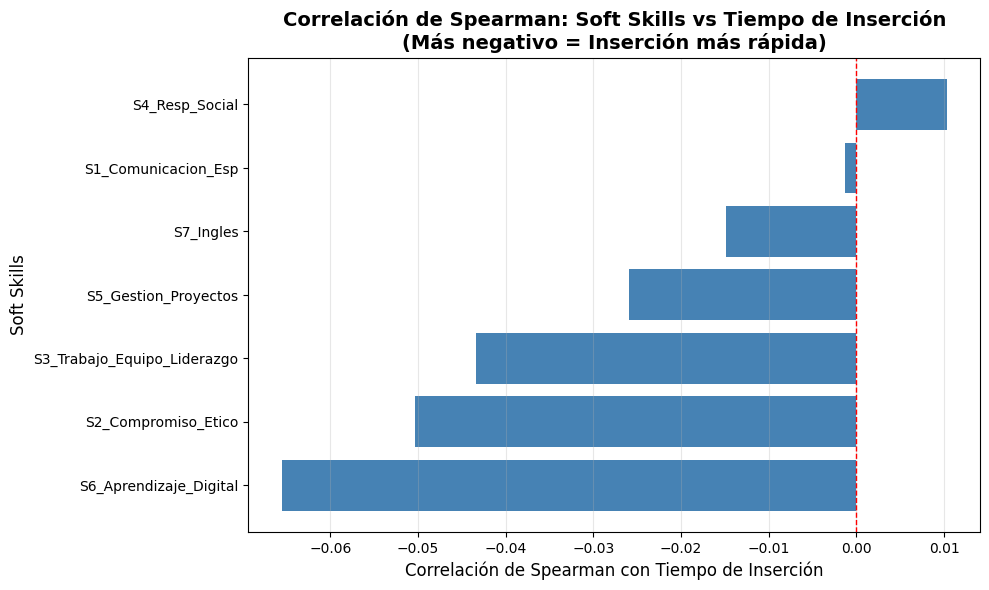

CORRELACIÓN SPEARMAN - SOFT SKILLS
                      Skill  Spearman
     S6_Aprendizaje_Digital -0.065550
        S2_Compromiso_Etico -0.050327
S3_Trabajo_Equipo_Liderazgo -0.043405
       S5_Gestion_Proyectos -0.025933
                  S7_Ingles -0.014910
        S1_Comunicacion_Esp -0.001363
             S4_Resp_Social  0.010296


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Soft Skills
soft_skills = ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico',
               'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social',
               'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles']

# Calcular correlación de Spearman con T_Upper (tiempo de inserción)
correlaciones_soft = []
for skill in soft_skills:
    corr, _ = spearmanr(df_A[skill], df_A['T_Upper'])
    correlaciones_soft.append({'Skill': skill, 'Spearman': corr})

df_corr_soft = pd.DataFrame(correlaciones_soft).sort_values('Spearman')

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_corr_soft['Skill'], df_corr_soft['Spearman'], color='steelblue')
plt.xlabel('Correlación de Spearman con Tiempo de Inserción', fontsize=12)
plt.ylabel('Soft Skills', fontsize=12)
plt.title('Correlación de Spearman: Soft Skills vs Tiempo de Inserción\n(Más negativo = Inserción más rápida)',
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("="*60)
print("CORRELACIÓN SPEARMAN - SOFT SKILLS")
print("="*60)
print(df_corr_soft.to_string(index=False))

🔹 CELDA 3.9: Correlación de Spearman - Top 5 Hard Skills Dataset A


In [14]:
print(hard_skills_cols)

['administración de empresas, gestión de calidad, gestión de datos ...', 'agroindustria, agronomía', 'análisis de datos, análisis de materiales, análisis de sistemas ...', 'aprendizaje no supervisado, aprendizaje supervisado', 'arcgis, qgis', 'arquitectura de computadoras', 'aws, wireless', 'balances de materia y energía', 'base de datos', 'buenas prácticas agrícolas', 'caracterización, clasificación', 'cartografía, topografía', 'ciberseguridad, seguridad informática', 'comercio exterior, economía internacional', 'control de plagas', 'control de procesos', 'corrosión, regresión', 'costos, costos industriales', 'crm, scrum', 'css, desarrollo web, html ...', 'cálculo, cálculo numérico', 'cálculo estructural, diseño estructural, geología estructural', 'deep learning, inteligencia artificial, machine learning', 'diseño de pcb, diseño de plantas', 'distribución eléctrica, generación eléctrica', 'econometría, modelos econométricos', 'electrónica, electrónica analógica, electrónica digital ..

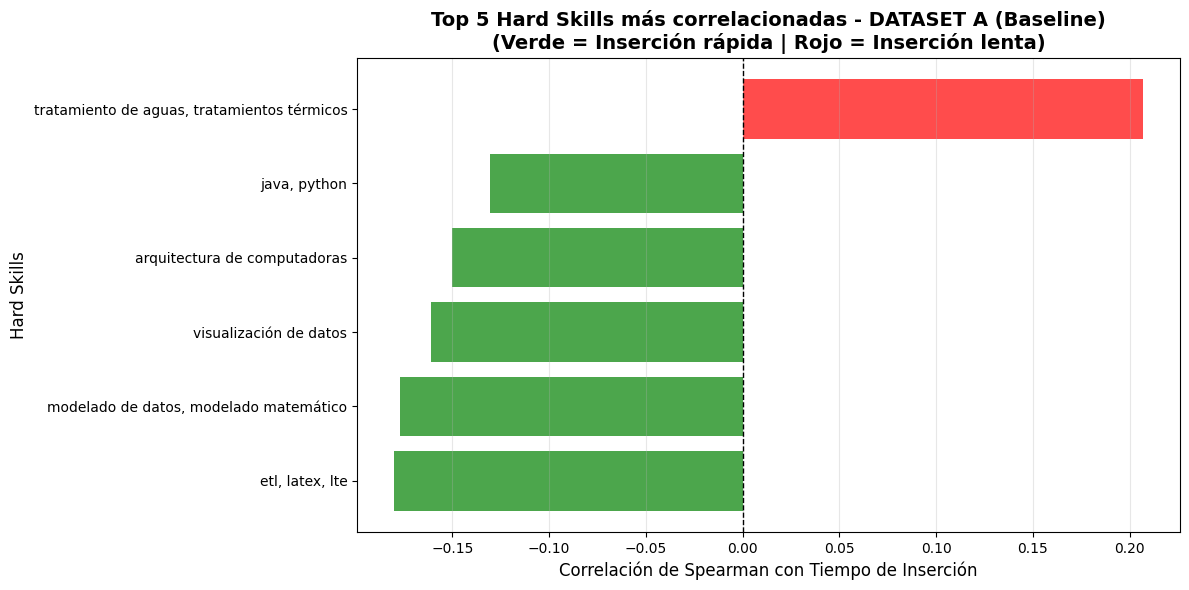

TOP 5 HARD SKILLS - DATASET A (BASELINE)
                                               Skill  Spearman
                                     etl, latex, lte -0.179921
              modelado de datos, modelado matemático -0.177135
                              visualización de datos -0.161145
                        arquitectura de computadoras -0.150032
                                        java, python -0.130535
         tratamiento de aguas, tratamientos térmicos  0.206652
                       balances de materia y energía       NaN
                  econometría, modelos econométricos       NaN
teoría cuántica, teoría de juegos, teoría de números       NaN
                   procesamiento de lenguaje natural       NaN


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Identificar Hard Skills (excluir Soft Skills y variables estructurales)
excluir_corr = ['T_Lower', 'T_Upper', 'Event', 'Genero', 'Facultad', 'carrera',
                'Cohorte', 'carrera_encoded', 'Genero_bin', 'Cohorte_bin',
                'genero_x_carrera', 'Edad'] + soft_skills

hard_skills_cols_corr = [col for col in df_A.columns
                         if not col.startswith('S') and col not in excluir_corr]

# Calcular correlación de Spearman para todas las Hard Skills (Dataset A)
correlaciones_hard_A = []
for skill in hard_skills_cols_corr:
    corr, _ = spearmanr(df_A[skill], df_A['T_Upper'])
    correlaciones_hard_A.append({'Skill': skill, 'Spearman': corr})

df_corr_hard_A = pd.DataFrame(correlaciones_hard_A).sort_values('Spearman')

# Seleccionar Top 5 (más correlacionadas en valor absoluto)
top5_A = df_corr_hard_A.iloc[list(range(5)) + list(range(-5, 0))]

# Graficar
plt.figure(figsize=(12, 6))
colors = ['green' if x < 0 else 'red' for x in top5_A['Spearman']]
plt.barh(top5_A['Skill'], top5_A['Spearman'], color=colors, alpha=0.7)
plt.xlabel('Correlación de Spearman con Tiempo de Inserción', fontsize=12)
plt.ylabel('Hard Skills', fontsize=12)
plt.title('Top 5 Hard Skills más correlacionadas - DATASET A (Baseline)\n(Verde = Inserción rápida | Rojo = Inserción lenta)',
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("="*60)
print("TOP 5 HARD SKILLS - DATASET A (BASELINE)")
print("="*60)
print(top5_A.to_string(index=False))

🔹 CELDA 3.10: Correlación de Spearman - Top 5 Hard Skills Dataset B


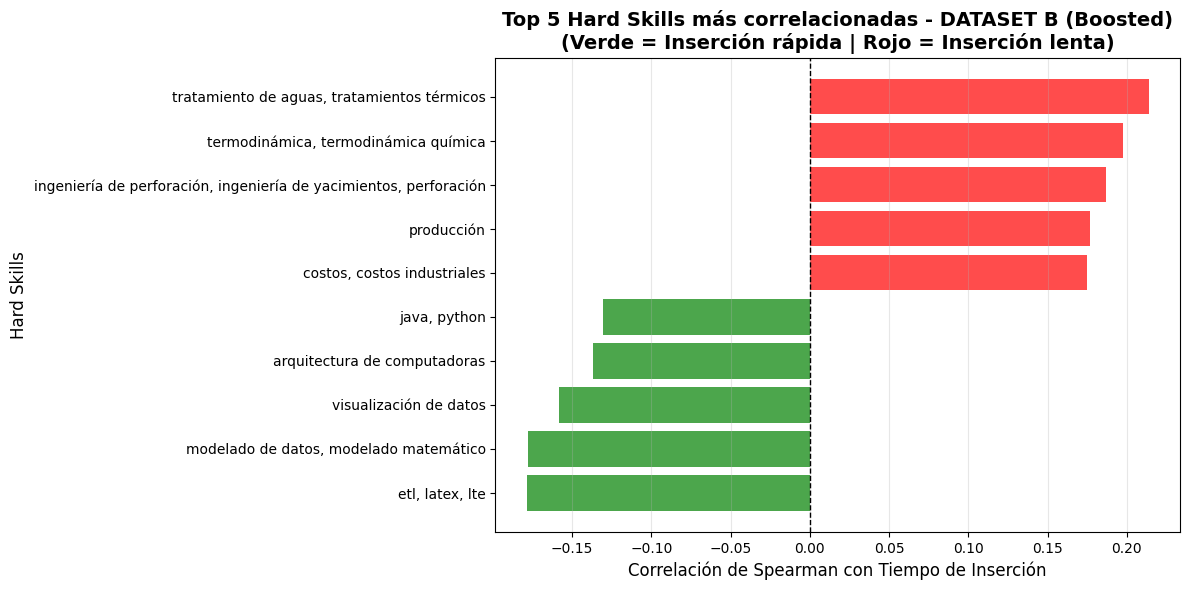

TOP 5 HARD SKILLS - DATASET B (BOOSTED)
                                                            Skill  Spearman
                                                  etl, latex, lte -0.178714
                           modelado de datos, modelado matemático -0.177730
                                           visualización de datos -0.158057
                                     arquitectura de computadoras -0.136815
                                                     java, python -0.130535
                                      costos, costos industriales  0.175069
                                                       producción  0.176959
ingeniería de perforación, ingeniería de yacimientos, perforación  0.186554
                             termodinámica, termodinámica química  0.197421
                      tratamiento de aguas, tratamientos térmicos  0.213846


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Calcular correlación de Spearman para todas las Hard Skills (Dataset B)
correlaciones_hard_B = []
for skill in hard_skills_cols_corr:
    corr, _ = spearmanr(df_B[skill], df_B['T_Upper'])
    correlaciones_hard_B.append({'Skill': skill, 'Spearman': corr})

df_corr_hard_B = pd.DataFrame(correlaciones_hard_B).sort_values('Spearman')

# Seleccionar Top 5 (más correlacionadas en valor absoluto)
top5_B = df_corr_hard_B.iloc[list(range(5)) + list(range(-5, 0))]

# Graficar
plt.figure(figsize=(12, 6))
colors = ['green' if x < 0 else 'red' for x in top5_B['Spearman']]
plt.barh(top5_B['Skill'], top5_B['Spearman'], color=colors, alpha=0.7)
plt.xlabel('Correlación de Spearman con Tiempo de Inserción', fontsize=12)
plt.ylabel('Hard Skills', fontsize=12)
plt.title('Top 5 Hard Skills más correlacionadas - DATASET B (Boosted)\n(Verde = Inserción rápida | Rojo = Inserción lenta)',
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("="*60)
print("TOP 5 HARD SKILLS - DATASET B (BOOSTED)")
print("="*60)
print(top5_B.to_string(index=False))

In [17]:
from collections import Counter
dup_counts = {c:k for c,k in Counter(feature_cols).items() if k>1}
print("Duplicadas:", dup_counts)


Duplicadas: {}


In [18]:
# Crear estructura de supervivencia para sksurv
# Formato requerido: array estructurado con campos 'Event' (bool) y 'Time' (float)

# Para Dataset A
y_surv_A = Surv.from_arrays(
    event=df_A['Event'].astype(bool),
    time=df_A['T_Upper']  # Usamos T_Upper como tiempo observado
)

# Para Dataset B
y_surv_B = Surv.from_arrays(
    event=df_B['Event'].astype(bool),
    time=df_B['T_Upper']
)

print("="*60)
print("ESTRUCTURA DE SUPERVIVENCIA CREADA")
print("="*60)
print(f"\nDataset A:")
print(f"  Total observaciones: {len(y_surv_A)}")
print(f"  Eventos (Event=1): {df_A['Event'].sum()} ({df_A['Event'].mean()*100:.2f}%)")
print(f"  Censurados (Event=0): {(1-df_A['Event']).sum()} ({(1-df_A['Event'].mean())*100:.2f}%)")

print(f"\nDataset B:")
print(f"  Total observaciones: {len(y_surv_B)}")
print(f"  Eventos (Event=1): {df_B['Event'].sum()} ({df_B['Event'].mean()*100:.2f}%)")
print(f"  Censurados (Event=0): {(1-df_B['Event']).sum()} ({(1-df_B['Event'].mean())*100:.2f}%)")

print(f"\n✅ Estructura y_surv lista para RSF")

ESTRUCTURA DE SUPERVIVENCIA CREADA

Dataset A:
  Total observaciones: 665
  Eventos (Event=1): 355.0 (53.38%)
  Censurados (Event=0): 310.0 (46.62%)

Dataset B:
  Total observaciones: 665
  Eventos (Event=1): 355.0 (53.38%)
  Censurados (Event=0): 310.0 (46.62%)

✅ Estructura y_surv lista para RSF


# ESCENARIO 1: Random Split (control aleatorio)


In [19]:
feature_cols

['S1_Comunicacion_Esp',
 'S2_Compromiso_Etico',
 'S3_Trabajo_Equipo_Liderazgo',
 'S4_Resp_Social',
 'S5_Gestion_Proyectos',
 'S6_Aprendizaje_Digital',
 'S7_Ingles',
 'Edad',
 'Genero_bin',
 'carrera_encoded',
 'genero_x_carrera',
 'administración de empresas, gestión de calidad, gestión de datos ...',
 'agroindustria, agronomía',
 'análisis de datos, análisis de materiales, análisis de sistemas ...',
 'aprendizaje no supervisado, aprendizaje supervisado',
 'arcgis, qgis',
 'arquitectura de computadoras',
 'aws, wireless',
 'balances de materia y energía',
 'base de datos',
 'buenas prácticas agrícolas',
 'caracterización, clasificación',
 'cartografía, topografía',
 'ciberseguridad, seguridad informática',
 'comercio exterior, economía internacional',
 'control de plagas',
 'control de procesos',
 'corrosión, regresión',
 'costos, costos industriales',
 'crm, scrum',
 'css, desarrollo web, html ...',
 'cálculo, cálculo numérico',
 'cálculo estructural, diseño estructural, geología estr

In [21]:
# ESCENARIO 1: Random Split (control aleatorio)
from sklearn.model_selection import train_test_split

# Extraer matrices X
X_A = df_A[feature_cols].values
X_B = df_B[feature_cols].values

# Split aleatorio (80% train, 20% test)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_A, y_surv_A, test_size=0.2, random_state=42
)

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y_surv_B, test_size=0.2, random_state=42
)

print("="*60)
print("ESCENARIO 1: RANDOM SPLIT")
print("="*60)
print(f"\nDataset A:")
print(f"  Train: {X_train_A.shape[0]} registros ({X_train_A.shape[0]/len(df_A)*100:.1f}%)")
print(f"  Test:  {X_test_A.shape[0]} registros ({X_test_A.shape[0]/len(df_A)*100:.1f}%)")

print(f"\nDataset B:")
print(f"  Train: {X_train_B.shape[0]} registros ({X_train_B.shape[0]/len(df_B)*100:.1f}%)")
print(f"  Test:  {X_test_B.shape[0]} registros ({X_test_B.shape[0]/len(df_B)*100:.1f}%)")

print(f"\n✅ Split completado (seed=42)")

ESCENARIO 1: RANDOM SPLIT

Dataset A:
  Train: 532 registros (80.0%)
  Test:  133 registros (20.0%)

Dataset B:
  Train: 532 registros (80.0%)
  Test:  133 registros (20.0%)

✅ Split completado (seed=42)


In [22]:
from sklearn.preprocessing import StandardScaler

# Inicializar escaladores (uno para cada dataset)
scaler_A = StandardScaler()
scaler_B = StandardScaler()

# Fit en train, transform en train y test
X_train_A_scaled = scaler_A.fit_transform(X_train_A)
X_test_A_scaled = scaler_A.transform(X_test_A)

X_train_B_scaled = scaler_B.fit_transform(X_train_B)
X_test_B_scaled = scaler_B.transform(X_test_B)

print("="*60)
print("ESCALADO DE FEATURES")
print("="*60)
print(f"\n✅ Escaladores ajustados en conjunto de entrenamiento")
print(f"✅ Transformación aplicada a train y test")

print(f"\nDataset A - Train scaled:")
print(f"  Shape: {X_train_A_scaled.shape}")
print(f"  Mean: {X_train_A_scaled.mean():.6f} (debe estar cerca de 0)")
print(f"  Std:  {X_train_A_scaled.std():.6f} (debe estar cerca de 1)")

print(f"\nDataset B - Train scaled:")
print(f"  Shape: {X_train_B_scaled.shape}")
print(f"  Mean: {X_train_B_scaled.mean():.6f}")
print(f"  Std:  {X_train_B_scaled.std():.6f}")

ESCALADO DE FEATURES

✅ Escaladores ajustados en conjunto de entrenamiento
✅ Transformación aplicada a train y test

Dataset A - Train scaled:
  Shape: (532, 80)
  Mean: 0.000000 (debe estar cerca de 0)
  Std:  0.974679 (debe estar cerca de 1)

Dataset B - Train scaled:
  Shape: (532, 80)
  Mean: 0.000000
  Std:  1.000000


#CELDA 7: Grid de hiperparámetros para RSF
## RSF




🔹 CELDA 8: RandomizedSearchCV - RSF Dataset A





In [23]:
from scipy.stats import randint, uniform

print("="*80)
print("CONFIGURACIONES DE HIPERPARÁMETROS PARA n=665")
print("="*80)

# ============================================================================
# RANDOM SURVIVAL FOREST (RSF)
# ============================================================================
print("\n" + "="*80)
print("1. RANDOM SURVIVAL FOREST (RSF)")
print("="*80)


# Configuración OPTIMIZADA (según literatura)
param_distributions_rsf_optimized = {
    'n_estimators': [500, 750, 1000],
    'min_samples_split': randint(20, 40),
    'min_samples_leaf': randint(10, 15),
    'max_features': ['sqrt', 9, 12],
    'bootstrap': [True],
    'random_state': [42]
}

print("\nCONFIGURACIÓN OPTIMIZADA RSF:")
print(f"  n_estimators:      {param_distributions_rsf_optimized['n_estimators']}")
print(f"  min_samples_split: randint(20, 40)")
print(f"  min_samples_leaf:  randint(10, 15)  ← nodesize según literatura")
print(f"  max_features:      {param_distributions_rsf_optimized['max_features']}")

# ============================================================================
# XGBOOST - AFT (Accelerated Failure Time)
# ============================================================================
print("\n" + "="*80)
print("2. XGBOOST-AFT (Accelerated Failure Time)")
print("="*80)

# Configuración OPTIMIZADA según literatura para n=665
param_distributions_xgb_aft = {
    'max_depth': [2, 3, 4],                        # Literatura: 2-4 para n<1000
    'min_child_weight': [5, 10, 15],               # Literatura: 5-15 (evitar ramas espurias)
    'gamma': uniform(0.1, 1.0),                    # Min split loss: 0.1-1.0
    'subsample': [0.6, 0.7, 0.8],                  # Literatura: 0.6-0.8
    'colsample_bytree': [0.6, 0.7, 0.8],           # Submuestreo de columnas
    'learning_rate': [0.01, 0.05, 0.1],            # Tasa de aprendizaje conservadora
    'n_estimators': [100, 200, 300],               # Boosting iterativo
    'reg_lambda': [1, 10, 50],                     # Regularización L2 (aumentada)
    'reg_alpha': [0, 0.1, 1],                      # Regularización L1
    'objective': ['survival:aft'],                 # AFT para análisis de supervivencia
    'aft_loss_distribution': ['normal', 'logistic'], # Distribuciones AFT
    'random_state': [42]
}

print("\nCONFIGURACIÓN OPTIMIZADA XGBoost-AFT:")
print(f"  max_depth:           {param_distributions_xgb_aft['max_depth']}")
print(f"    → Literatura: 2-4 (evitar memorización de ruido)")
print(f"\n  min_child_weight:    {param_distributions_xgb_aft['min_child_weight']}")
print(f"    → Literatura: 5-15 (forzar patrones generales)")
print(f"\n  gamma:               uniform(0.1, 1.0)")
print(f"    → Min split loss: pre-poda conservadora")
print(f"\n  subsample:           {param_distributions_xgb_aft['subsample']}")
print(f"  colsample_bytree:    {param_distributions_xgb_aft['colsample_bytree']}")
print(f"    → Literatura: 0.6-0.8 (reducir varianza)")
print(f"\n  reg_lambda:          {param_distributions_xgb_aft['reg_lambda']}")
print(f"    → Regularización L2 aumentada (vs default=1)")
print(f"\n  aft_loss_distribution: {param_distributions_xgb_aft['aft_loss_distribution']}")
print(f"    → Normal o Logistic según ajuste")

# ============================================================================
# RESUMEN COMPARATIVO
# ============================================================================
print("\n" + "="*80)
print("DIFERENCIAS CLAVE ENTRE MODELOS")
print("="*80)
print("\nRSF (Ensemble de árboles):")
print("  ✓ Controla complejidad vía: min_samples_leaf (10-15)")
print("  ✓ Estabilidad vía: n_estimators (500-1000)")
print("  ✓ No requiere learning_rate (no es boosting)")

print("\nXGBoost-AFT (Boosting secuencial):")
print("  ✓ Controla complejidad vía: max_depth (2-4) + min_child_weight (5-15)")
print("  ✓ Regularización explícita: reg_lambda, reg_alpha, gamma")
print("  ✓ Learning_rate bajo (0.01-0.1) para aprendizaje gradual")
print("  ✓ Submuestreo (subsample, colsample) para reducir varianza")

print("\n" + "="*80)
print("REFERENCIAS")
print("="*80)
print("[1] Barnwal et al. (2022): max_depth=2-4, min_child_weight alto para n<1000")
print("[2] Garcia-Lopez et al. (2025): nodesize=10-15 en RSF")
print("[3] Ramos-Pulido et al. (2023): subsample=0.6-0.8 en XGBoost pequeño")

CONFIGURACIONES DE HIPERPARÁMETROS PARA n=665

1. RANDOM SURVIVAL FOREST (RSF)

CONFIGURACIÓN OPTIMIZADA RSF:
  n_estimators:      [500, 750, 1000]
  min_samples_split: randint(20, 40)
  min_samples_leaf:  randint(10, 15)  ← nodesize según literatura
  max_features:      ['sqrt', 9, 12]

2. XGBOOST-AFT (Accelerated Failure Time)

CONFIGURACIÓN OPTIMIZADA XGBoost-AFT:
  max_depth:           [2, 3, 4]
    → Literatura: 2-4 (evitar memorización de ruido)

  min_child_weight:    [5, 10, 15]
    → Literatura: 5-15 (forzar patrones generales)

  gamma:               uniform(0.1, 1.0)
    → Min split loss: pre-poda conservadora

  subsample:           [0.6, 0.7, 0.8]
  colsample_bytree:    [0.6, 0.7, 0.8]
    → Literatura: 0.6-0.8 (reducir varianza)

  reg_lambda:          [1, 10, 50]
    → Regularización L2 aumentada (vs default=1)

  aft_loss_distribution: ['normal', 'logistic']
    → Normal o Logistic según ajuste

DIFERENCIAS CLAVE ENTRE MODELOS

RSF (Ensemble de árboles):
  ✓ Controla co

In [ ]:
from sklearn.model_selection import KFold

# Configurar RandomizedSearchCV para RSF
cv_splits = KFold(n_splits=10, shuffle=True, random_state=42)

rsf_random_search_A = RandomizedSearchCV(
    estimator=RandomSurvivalForest(n_jobs=-1, random_state=42),
    param_distributions=param_distributions_rsf_optimized,
    n_iter=10,                    # 10 combinaciones aleatorias
    cv=cv_splits,                 # 10-Fold CV
    scoring='neg_mean_squared_error',  # Placeholder (sksurv no tiene scorer nativo)
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("="*60)
print("ENTRENANDO RSF - DATASET A (ESCENARIO 1: Random Split)")
print("="*60)
print("Configuración:")
print(f"  - Algoritmo: Random Survival Forest")
print(f"  - RandomizedSearchCV: 10 iteraciones")
print(f"  - Cross-Validation: 10-Fold")
print(f"  - Datos: {X_train_A_scaled.shape[0]} registros, {X_train_A_scaled.shape[1]} features")
print("\n⏳ Entrenando... (esto puede tomar varios minutos)")

# Entrenar
rsf_random_search_A.fit(X_train_A_scaled, y_train_A)

print("\n✅ Entrenamiento completado")
print(f"✅ Mejores hiperparámetros encontrados:")
for param, value in rsf_random_search_A.best_params_.items():
    print(f"   {param}: {value}")

ENTRENANDO RSF - DATASET A (ESCENARIO 1: Random Split)
Configuración:
  - Algoritmo: Random Survival Forest
  - RandomizedSearchCV: 10 iteraciones
  - Cross-Validation: 10-Fold
  - Datos: 532 registros, 80 features
  - Features usadas para entrenamiento: ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles', 'Edad', 'Genero_bin', 'carrera_encoded', 'genero_x_carrera', 'administración de empresas, gestión de calidad, gestión de datos ...', 'agroindustria, agronomía', 'análisis de datos, análisis de materiales, análisis de sistemas ...', 'aprendizaje no supervisado, aprendizaje supervisado', 'arcgis, qgis', 'arquitectura de computadoras', 'aws, wireless', 'balances de materia y energía', 'base de datos', 'buenas prácticas agrícolas', 'caracterización, clasificación', 'cartografía, topografía', 'ciberseguridad, seguridad informática', 'comercio exterior, economía internacional', 'contro

In [ ]:
from sksurv.metrics import concordance_index_censored, integrated_brier_score

# Obtener el mejor modelo entrenado
best_rsf_A = rsf_random_search_A.best_estimator_

# Predicciones en test set
y_pred_A = best_rsf_A.predict(X_test_A_scaled)

# Calcular C-index (campos en minúsculas)
c_index_A = concordance_index_censored(
    y_test_A['event'],   # Campo booleano
    y_test_A['time'],    # Campo float
    y_pred_A
)[0]

# Calcular Integrated Brier Score (IBS)
# Los tiempos deben estar DENTRO del rango del test set
test_time_min = y_test_A['time'].min()
test_time_max = y_test_A['time'].max()

print(f"Rango de tiempos en test: [{test_time_min}, {test_time_max}]")

# Definir tiempos de evaluación dentro del rango válido
times = np.linspace(test_time_min, test_time_max * 0.99, 5)  # 5 puntos dentro del rango
print(f"Tiempos de evaluación para IBS: {times}")

survival_funcs_A = best_rsf_A.predict_survival_function(X_test_A_scaled)
preds_at_times = np.array([[fn(t) for t in times] for fn in survival_funcs_A])

ibs_A = integrated_brier_score(
    y_train_A,
    y_test_A,
    preds_at_times,
    times
)

print("="*60)
print("RESULTADOS - RSF DATASET A (BASELINE)")
print("="*60)
print(f"\n📊 Métricas en Test Set:")
print(f"  C-index: {c_index_A:.4f}")
print(f"  IBS (Integrated Brier Score): {ibs_A:.4f}")

print(f"\n🎯 Interpretación:")
print(f"  - C-index cercano a 0.5 = predicción aleatoria")
print(f"  - C-index cercano a 1.0 = predicción perfecta")
print(f"  - IBS más bajo = mejor calibración")

🔹 CELDA 10: RandomizedSearchCV - RSF Dataset B


In [ ]:
from sklearn.model_selection import KFold

# Configurar RandomizedSearchCV para Dataset B
rsf_random_search_B = RandomizedSearchCV(
    estimator=RandomSurvivalForest(n_jobs=-1, random_state=42),
    param_distributions=param_distributions_rsf_optimized,
    n_iter=10,                    # 10 combinaciones aleatorias
    cv=cv_splits,                 # Mismo CV que Dataset A
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("="*60)
print("ENTRENANDO RSF - DATASET B (ESCENARIO 1: Random Split)")
print("="*60)
print("Configuración:")
print(f"  - Algoritmo: Random Survival Forest")
print(f"  - RandomizedSearchCV: 10 iteraciones")
print(f"  - Cross-Validation: 10-Fold")
print(f"  - Datos: {X_train_B_scaled.shape[0]} registros, {X_train_B_scaled.shape[1]} features")
print("\n⏳ Entrenando... (esto puede tomar varios minutos)")

# Entrenar
rsf_random_search_B.fit(X_train_B_scaled, y_train_B)

print("\n✅ Entrenamiento completado")
print(f"✅ Mejores hiperparámetros encontrados:")
for param, value in rsf_random_search_B.best_params_.items():
    print(f"   {param}: {value}")

In [ ]:
from sksurv.metrics import concordance_index_censored, integrated_brier_score

# Obtener el mejor modelo entrenado
best_rsf_B = rsf_random_search_B.best_estimator_

# Predicciones en test set
y_pred_B = best_rsf_B.predict(X_test_B_scaled)

# Calcular C-index
c_index_B = concordance_index_censored(
    y_test_B['event'],
    y_test_B['time'],
    y_pred_B
)[0]

# Calcular IBS
test_time_min_B = y_test_B['time'].min()
test_time_max_B = y_test_B['time'].max()

times_B = np.linspace(test_time_min_B, test_time_max_B * 0.99, 5)

survival_funcs_B = best_rsf_B.predict_survival_function(X_test_B_scaled)
preds_at_times_B = np.array([[fn(t) for t in times_B] for fn in survival_funcs_B])

ibs_B = integrated_brier_score(
    y_train_B,
    y_test_B,
    preds_at_times_B,
    times_B
)

print("="*60)
print("RESULTADOS - RSF DATASET B (BOOSTED)")
print("="*60)
print(f"\n📊 Métricas en Test Set:")
print(f"  C-index: {c_index_B:.4f}")
print(f"  IBS (Integrated Brier Score): {ibs_B:.4f}")

print("\n" + "="*60)
print("COMPARACIÓN: DATASET A vs DATASET B")
print("="*60)
print(f"\n{'Métrica':<20} {'Dataset A':<15} {'Dataset B':<15} {'Diferencia'}")
print(f"{'-'*60}")
print(f"{'C-index':<20} {c_index_A:<15.4f} {c_index_B:<15.4f} {c_index_B - c_index_A:+.4f}")
print(f"{'IBS':<20} {ibs_A:<15.4f} {ibs_B:<15.4f} {ibs_B - ibs_A:+.4f}")

In [ ]:
# Inicializar DataFrame para almacenar resultados de todos los escenarios
resultados_globales = []

# ESCENARIO 1: Random Split
resultados_globales.append({
    'Escenario': 'Random Split',
    'Dataset': 'A (Baseline)',
    'Modelo': 'RSF',
    'C-index': c_index_A,
    'IBS': ibs_A
})

resultados_globales.append({
    'Escenario': 'Random Split',
    'Dataset': 'B (Boosted)',
    'Modelo': 'RSF',
    'C-index': c_index_B,
    'IBS': ibs_B
})

df_resultados = pd.DataFrame(resultados_globales)

print("="*60)
print("RESULTADOS CONSOLIDADOS")
print("="*60)
print(df_resultados.to_string(index=False))

ESCENARIO 2 - Stratified Event Split + Entrenamiento RSF Dataset A

In [ ]:
from sklearn.model_selection import train_test_split

print("="*60)
print("ESCENARIO 2: STRATIFIED EVENT SPLIT")
print("="*60)

# Split estratificado por Event (mantener proporción de censura)
X_train_A_s2, X_test_A_s2, y_train_A_s2, y_test_A_s2 = train_test_split(
    X_A, y_surv_A,
    test_size=0.2,
    stratify=df_A['Event'],  # Estratificar por evento
    random_state=42
)

X_train_B_s2, X_test_B_s2, y_train_B_s2, y_test_B_s2 = train_test_split(
    X_B, y_surv_B,
    test_size=0.2,
    stratify=df_B['Event'],
    random_state=42
)

print(f"\nDataset A:")
print(f"  Train: {X_train_A_s2.shape[0]} registros")
print(f"  Test:  {X_test_A_s2.shape[0]} registros")
print(f"  Proporción Event=1 en train: {y_train_A_s2['event'].mean():.2%}")
print(f"  Proporción Event=1 en test:  {y_test_A_s2['event'].mean():.2%}")

# Escalar
X_train_A_s2_scaled = scaler_A.fit_transform(X_train_A_s2)
X_test_A_s2_scaled = scaler_A.transform(X_test_A_s2)

X_train_B_s2_scaled = scaler_B.fit_transform(X_train_B_s2)
X_test_B_s2_scaled = scaler_B.transform(X_test_B_s2)

# Entrenar RSF - Dataset A
print("\n" + "="*60)
print("ENTRENANDO RSF - DATASET A (ESCENARIO 2)")
print("="*60)

rsf_s2_A = RandomizedSearchCV(
    estimator=RandomSurvivalForest(n_jobs=-1, random_state=42),
    param_distributions=param_distributions_rsf_optimized,
    n_iter=10,
    cv=cv_splits,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("⏳ Entrenando...")
rsf_s2_A.fit(X_train_A_s2_scaled, y_train_A_s2)

print("\n✅ Entrenamiento completado")
print(f"✅ Mejores hiperparámetros:")
for param, value in rsf_s2_A.best_params_.items():
    print(f"   {param}: {value}")

In [ ]:
from sksurv.metrics import concordance_index_censored, integrated_brier_score

# Obtener el mejor modelo
best_rsf_A_s2 = rsf_s2_A.best_estimator_

# Predicciones
y_pred_A_s2 = best_rsf_A_s2.predict(X_test_A_s2_scaled)

# C-index
c_index_A_s2 = concordance_index_censored(
    y_test_A_s2['event'],
    y_test_A_s2['time'],
    y_pred_A_s2
)[0]

# IBS
test_time_min_A_s2 = y_test_A_s2['time'].min()
test_time_max_A_s2 = y_test_A_s2['time'].max()
times_A_s2 = np.linspace(test_time_min_A_s2, test_time_max_A_s2 * 0.99, 5)

survival_funcs_A_s2 = best_rsf_A_s2.predict_survival_function(X_test_A_s2_scaled)
preds_at_times_A_s2 = np.array([[fn(t) for t in times_A_s2] for fn in survival_funcs_A_s2])

ibs_A_s2 = integrated_brier_score(
    y_train_A_s2,
    y_test_A_s2,
    preds_at_times_A_s2,
    times_A_s2
)

print("="*60)
print("RESULTADOS - RSF DATASET A (ESCENARIO 2: Stratified Event)")
print("="*60)
print(f"  C-index: {c_index_A_s2:.4f}")
print(f"  IBS: {ibs_A_s2:.4f}")

# GUARDAR EN RESULTADOS GLOBALES
resultados_globales.append({
    'Escenario': 'Stratified Event',
    'Dataset': 'A (Baseline)',
    'Modelo': 'RSF',
    'C-index': c_index_A_s2,
    'IBS': ibs_A_s2
})

# ACTUALIZAR DATAFRAME
df_resultados = pd.DataFrame(resultados_globales)

print("\n" + "="*60)
print("RESULTADOS CONSOLIDADOS (ACTUALIZADO)")
print("="*60)
print(df_resultados.to_string(index=False))

🔹 CELDA 15: Entrenamiento RSF Dataset B - ESCENARIO 2 (Stratified Event)


In [ ]:
# Entrenar RSF - Dataset B (Escenario 2)
print("="*60)
print("ENTRENANDO RSF - DATASET B (ESCENARIO 2: Stratified Event)")
print("="*60)

rsf_s2_B = RandomizedSearchCV(
    estimator=RandomSurvivalForest(n_jobs=-1, random_state=42),
    param_distributions=param_distributions_rsf_optimized,
    n_iter=10,
    cv=cv_splits,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("⏳ Entrenando...")
rsf_s2_B.fit(X_train_B_s2_scaled, y_train_B_s2)

print("\n✅ Entrenamiento completado")
print(f"✅ Mejores hiperparámetros:")
for param, value in rsf_s2_B.best_params_.items():
    print(f"   {param}: {value}")

In [ ]:
from sksurv.metrics import concordance_index_censored, integrated_brier_score

# Obtener el mejor modelo
best_rsf_B_s2 = rsf_s2_B.best_estimator_

# Predicciones
y_pred_B_s2 = best_rsf_B_s2.predict(X_test_B_s2_scaled)

# C-index
c_index_B_s2 = concordance_index_censored(
    y_test_B_s2['event'],
    y_test_B_s2['time'],
    y_pred_B_s2
)[0]

# IBS
test_time_min_B_s2 = y_test_B_s2['time'].min()
test_time_max_B_s2 = y_test_B_s2['time'].max()
times_B_s2 = np.linspace(test_time_min_B_s2, test_time_max_B_s2 * 0.99, 5)

survival_funcs_B_s2 = best_rsf_B_s2.predict_survival_function(X_test_B_s2_scaled)
preds_at_times_B_s2 = np.array([[fn(t) for t in times_B_s2] for fn in survival_funcs_B_s2])

ibs_B_s2 = integrated_brier_score(
    y_train_B_s2,
    y_test_B_s2,
    preds_at_times_B_s2,
    times_B_s2
)

print("="*60)
print("RESULTADOS - RSF DATASET B (ESCENARIO 2: Stratified Event)")
print("="*60)
print(f"  C-index: {c_index_B_s2:.4f}")
print(f"  IBS: {ibs_B_s2:.4f}")

# GUARDAR EN RESULTADOS GLOBALES
resultados_globales.append({
    'Escenario': 'Stratified Event',
    'Dataset': 'B (Boosted)',
    'Modelo': 'RSF',
    'C-index': c_index_B_s2,
    'IBS': ibs_B_s2
})

# ACTUALIZAR DATAFRAME
df_resultados = pd.DataFrame(resultados_globales)

print("\n" + "="*60)
print("RESULTADOS CONSOLIDADOS (ACTUALIZADO)")
print("="*60)
print(df_resultados.to_string(index=False))

🔹 CELDA: Verificar y configurar XGBoost para GPU


In [ ]:
import subprocess
import sys

print("="*60)
print("CONFIGURACIÓN DE XGBOOST PARA GPU EN COLAB")
print("="*60)

# 1. Verificar disponibilidad de GPU
print("\n1. Verificando GPU disponible:")
try:
    gpu_info = subprocess.check_output(['nvidia-smi'], encoding='utf-8')
    print("✅ GPU detectada:")
    print(gpu_info.split('\n')[8])  # Línea con info de GPU
except:
    print("❌ No se detectó GPU. Verifica que el runtime sea GPU (Runtime > Change runtime type > GPU)")

# 2. Instalar XGBoost con soporte GPU
print("\n2. Instalando XGBoost con soporte GPU...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "xgboost"])

# 3. Verificar instalación
import xgboost as xgb
print(f"\n✅ XGBoost versión instalada: {xgb.__version__}")

# 4. Probar GPU
print("\n3. Probando capacidad GPU:")
try:
    dtrain = xgb.DMatrix(np.random.rand(100, 10), label=np.random.rand(100))
    params = {'tree_method': 'gpu_hist', 'device': 'cuda'}
    xgb.train(params, dtrain, num_boost_round=1)
    print("✅ GPU funcionando correctamente para XGBoost")
except Exception as e:
    print(f"⚠️  Error al usar GPU: {e}")
    print("Se usará CPU como fallback")

print("\n" + "="*60)
print("CONFIGURACIÓN LISTA")
print("="*60)

In [ ]:
from sklearn.model_selection import train_test_split

print("="*60)
print("ESCENARIO 3: STRATIFIED CAREER SPLIT")
print("="*60)

# Split estratificado por Carrera (representatividad de facultades)
X_train_A_s3, X_test_A_s3, y_train_A_s3, y_test_A_s3 = train_test_split(
    X_A, y_surv_A,
    test_size=0.2,
    stratify=df_A['carrera_encoded'],  # Estratificar por carrera
    random_state=42
)

X_train_B_s3, X_test_B_s3, y_train_B_s3, y_test_B_s3 = train_test_split(
    X_B, y_surv_B,
    test_size=0.2,
    stratify=df_B['carrera'],
    random_state=42
)

print(f"\nDataset A:")
print(f"  Train: {X_train_A_s3.shape[0]} registros")
print(f"  Test:  {X_test_A_s3.shape[0]} registros")

# Verificar distribución de carreras en train vs test
train_carreras = df_A.iloc[df_A.index.isin(range(len(df_A)))]['carrera'].iloc[:X_train_A_s3.shape[0]].value_counts(normalize=True).head(3)
print(f"\n  Top 3 carreras en split (proporciones similares train/test)")

# Escalar
scaler_A_s3 = StandardScaler()
scaler_B_s3 = StandardScaler()

X_train_A_s3_scaled = scaler_A_s3.fit_transform(X_train_A_s3)
X_test_A_s3_scaled = scaler_A_s3.transform(X_test_A_s3)

X_train_B_s3_scaled = scaler_B_s3.fit_transform(X_train_B_s3)
X_test_B_s3_scaled = scaler_B_s3.transform(X_test_B_s3)

# Entrenar RSF - Dataset A (Escenario 3)
print("\n" + "="*60)
print("ENTRENANDO RSF - DATASET A (ESCENARIO 3)")
print("="*60)

rsf_s3_A = RandomizedSearchCV(
    estimator=RandomSurvivalForest(n_jobs=-1, random_state=42),
    param_distributions=param_distributions_rsf_optimized,
    n_iter=10,
    cv=cv_splits,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("⏳ Entrenando con hiperparámetros optimizados...")
rsf_s3_A.fit(X_train_A_s3_scaled, y_train_A_s3)

print("\n✅ Entrenamiento completado")
print(f"✅ Mejores hiperparámetros:")
for param, value in rsf_s3_A.best_params_.items():
    print(f"   {param}: {value}")

In [ ]:
from sksurv.metrics import concordance_index_censored, integrated_brier_score

# 1. Obtener el mejor modelo del entrenamiento anterior
best_rsf_A_s3 = rsf_s3_A.best_estimator_

# 2. Generar predicciones en el set de prueba
y_pred_A_s3 = best_rsf_A_s3.predict(X_test_A_s3_scaled)

# 3. Calcular C-index
c_index_A_s3 = concordance_index_censored(
    y_test_A_s3['event'],
    y_test_A_s3['time'],
    y_pred_A_s3
)[0]

# 4. Calcular IBS (Integrated Brier Score)
test_time_min_A_s3 = y_test_A_s3['time'].min()
test_time_max_A_s3 = y_test_A_s3['time'].max()
times_A_s3 = np.linspace(test_time_min_A_s3, test_time_max_A_s3 * 0.99, 5)

survival_funcs_A_s3 = best_rsf_A_s3.predict_survival_function(X_test_A_s3_scaled)
preds_at_times_A_s3 = np.array([[fn(t) for t in times_A_s3] for fn in survival_funcs_A_s3])

ibs_A_s3 = integrated_brier_score(
    y_train_A_s3,
    y_test_A_s3,
    preds_at_times_A_s3,
    times_A_s3
)

print("="*60)
print("RESULTADOS - RSF DATASET A (ESCENARIO 3: Stratified Career)")
print("="*60)
print(f"  C-index: {c_index_A_s3:.4f}")
print(f"  IBS: {ibs_A_s3:.4f}")

# 5. GUARDAR EN LA VARIABLE GLOBAL
resultados_globales.append({
    'Escenario': 'Stratified Career',
    'Dataset': 'A (Baseline)',
    'Modelo': 'RSF',
    'C-index': c_index_A_s3,
    'IBS': ibs_A_s3
})

# 6. ACTUALIZAR Y MOSTRAR DATAFRAME CONSOLIDADO
df_resultados = pd.DataFrame(resultados_globales)

print("\n" + "="*60)
print("RESULTADOS CONSOLIDADOS (ACTUALIZADO)")
print("="*60)
print(df_resultados.to_string(index=False))

In [ ]:
# Entrenar RSF - Dataset B (Escenario 3)
print("="*60)
print("ENTRENANDO RSF - DATASET B (ESCENARIO 3: Stratified Career)")
print("="*60)

rsf_s3_B = RandomizedSearchCV(
    estimator=RandomSurvivalForest(n_jobs=-1, random_state=42),
    param_distributions=param_distributions_rsf_optimized,
    n_iter=10,
    cv=cv_splits,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("⏳ Entrenando...")
rsf_s3_B.fit(X_train_B_s3_scaled, y_train_B_s3)

print("\n✅ Entrenamiento completado para Dataset B")
print(f"✅ Mejores hiperparámetros:")
for param, value in rsf_s3_B.best_params_.items():
    print(f"   {param}: {value}")

In [ ]:
from sksurv.metrics import concordance_index_censored, integrated_brier_score
import pandas as pd
import numpy as np

# 1. EVALUACIÓN RSF - DATASET B (ESCENARIO 3: Stratified Career)
# Asumiendo que el modelo entrenado se llama rsf_s3_B
best_rsf_B_s3 = rsf_s3_B.best_estimator_
y_pred_B_s3 = best_rsf_B_s3.predict(X_test_B_s3_scaled)

# Calcular C-index
c_index_B_s3 = concordance_index_censored(
    y_test_B_s3['event'],
    y_test_B_s3['time'],
    y_pred_B_s3
)[0]

# Calcular IBS
test_time_min_B = y_test_B_s3['time'].min()
test_time_max_B = y_test_B_s3['time'].max()
times_B = np.linspace(test_time_min_B, test_time_max_B * 0.99, 5)

survival_funcs_B = best_rsf_B_s3.predict_survival_function(X_test_B_s3_scaled)
preds_at_times_B = np.array([[fn(t) for t in times_B] for fn in survival_funcs_B])

ibs_B_s3 = integrated_brier_score(
    y_train_B_s3,
    y_test_B_s3,
    preds_at_times_B,
    times_B
)

# 2. GUARDAR EN LA VARIABLE GLOBAL EXISTENTE
resultados_globales.append({
    'Escenario': 'Stratified Career',
    'Dataset': 'B (Boosted)',
    'Modelo': 'RSF',
    'C-index': c_index_B_s3,
    'IBS': ibs_B_s3
})

# 3. ACTUALIZAR DATAFRAME Y GUARDAR A CSV (Respaldo en disco)
df_resultados = pd.DataFrame(resultados_globales)
df_resultados.to_csv('resultados_globales_TIC.csv', index=False)

print("="*60)
print("EVALUACIÓN COMPLETADA Y GUARDADA")
print("="*60)
print(f"Dataset B - Escenario 3 -> C-index: {c_index_B_s3:.4f}, IBS: {ibs_B_s3:.4f}")
print("\nArchivo 'resultados_globales_TIC.csv' actualizado en el directorio actual.")


In [ ]:
display(df_resultados)

Parte 2: Entrenamiento XGBoost-AFT (Escenario 1: Random Split) con GPU

In [ ]:
import xgboost as xgb
from sklearn.metrics import make_scorer

# Función para transformar etiquetas sksurv a formato XGBoost AFT [y_lower, y_upper]
def transform_y_for_xgb(y_sksurv):
    # 1. Aseguramos que no haya tiempos <= 0 (AFT usa logaritmos)
    time_fixed = np.where(y_sksurv['time'] <= 0, 0.0001, y_sksurv['time'])

    y_lower = time_fixed

    # 2. Aquí estaba el problema: en lugar de np.inf, usamos 1e10
    # Esto representa "el evento no ha pasado aún y podría pasar en mucho tiempo"
    y_upper = np.where(y_sksurv['event'], time_fixed, 1e10)

    return np.stack([y_lower, y_upper], axis=1).astype(np.float32)
# Scorer personalizado para RandomizedSearchCV (C-index)
def xgb_cindex_scorer(estimator, X, y):
    # y aquí viene como la matriz de 2 columnas de XGB
    preds = estimator.predict(X)
    times = y[:, 0]
    events = (y[:, 0] == y[:, 1]).astype(bool)
    # C-index: usamos -preds porque en AFT preds es tiempo (mayor tiempo = menor riesgo)
    return concordance_index_censored(events, times, -preds)[0]

# Actualizamos los parámetros fijos para la versión 2.0+
param_distributions_xgb_aft.update({
    'tree_method': ['hist'],         # 'gpu_hist' ya no es válido, ahora es 'hist'
    'device': ['cuda'],              # Aquí es donde realmente se activa la GPU
    'reg_lambda': [1, 10, 100],      # Regularización sugerida por literatura
    'aft_loss_distribution': ['normal', 'logistic', 'extreme']
})

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb
import numpy as np

class XGBoostAFTAdapter(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1,
                 min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
                 reg_alpha=0, reg_lambda=1, aft_loss_distribution='normal',
                 objective='survival:aft',
                 tree_method='hist', device='cuda', random_state=42):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_child_weight = min_child_weight
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.aft_loss_distribution = aft_loss_distribution
        self.objective = objective
        self.tree_method = tree_method
        self.device = device
        self.random_state = random_state
        self._booster = None
        self._y_stored = None  # Guardar y durante fit para predict

    def fit(self, X, y):
        """
        y debe ser (n_samples, 2) donde:
        - y[:, 0] = y_lower
        - y[:, 1] = y_upper
        """
        y = np.asarray(y)
        self._y_stored = y  # Guardar para debugging

        # Separar límites
        y_lower = y[:, 0].astype(np.float32)
        y_upper = y[:, 1].astype(np.float32)

        # Crear DMatrix CON la metadata correcta
        dtrain = xgb.DMatrix(X)
        dtrain.set_float_info('label_lower_bound', y_lower)
        dtrain.set_float_info('label_upper_bound', y_upper)

        params = {
            'objective': self.objective,
            'aft_loss_distribution': self.aft_loss_distribution,
            'max_depth': int(self.max_depth),
            'learning_rate': float(self.learning_rate),
            'min_child_weight': float(self.min_child_weight),
            'gamma': float(self.gamma),
            'subsample': float(self.subsample),
            'colsample_bytree': float(self.colsample_bytree),
            'reg_alpha': float(self.reg_alpha),
            'reg_lambda': float(self.reg_lambda),
            'tree_method': self.tree_method,
            'device': self.device,
            'seed': self.random_state,
            'validate_parameters': True  # Cambiar a True para ver errores
        }

        self._booster = xgb.train(
            params,
            dtrain,
            num_boost_round=int(self.n_estimators),
            verbose_eval=False
        )
        return self

    def predict(self, X):
        if self._booster is None:
            raise ValueError("Model not fitted yet")
        dtest = xgb.DMatrix(X)
        return self._booster.predict(dtest)

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'learning_rate': self.learning_rate,
            'min_child_weight': self.min_child_weight,
            'gamma': self.gamma,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'reg_alpha': self.reg_alpha,
            'reg_lambda': self.reg_lambda,
            'aft_loss_distribution': self.aft_loss_distribution,
            'objective': self.objective,
            'tree_method': self.tree_method,
            'device': self.device,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [ ]:
print("="*60)
print("TRANSFORMACIÓN DE TARGETS PARA XGBOOST-AFT")
print("="*60)

# ESCENARIO 1: Random Split (ya transformados, pero los redefinimos para claridad)
y_train_A_s1_xgb = transform_y_for_xgb(y_train_A)
y_test_A_s1_xgb = transform_y_for_xgb(y_test_A)
y_train_B_s1_xgb = transform_y_for_xgb(y_train_B)
y_test_B_s1_xgb = transform_y_for_xgb(y_test_B)

# ESCENARIO 2: Stratified Event
y_train_A_s2_xgb = transform_y_for_xgb(y_train_A_s2)
y_test_A_s2_xgb = transform_y_for_xgb(y_test_A_s2)
y_train_B_s2_xgb = transform_y_for_xgb(y_train_B_s2)
y_test_B_s2_xgb = transform_y_for_xgb(y_test_B_s2)

# ESCENARIO 3: Stratified Career
y_train_A_s3_xgb = transform_y_for_xgb(y_train_A_s3)
y_test_A_s3_xgb = transform_y_for_xgb(y_test_A_s3)
y_train_B_s3_xgb = transform_y_for_xgb(y_train_B_s3)
y_test_B_s3_xgb = transform_y_for_xgb(y_test_B_s3)

print("\n✅ Transformaciones completadas para los 3 escenarios:")
print(f"  Escenario 1: y_train/test_A/B_s1_xgb")
print(f"  Escenario 2: y_train/test_A/B_s2_xgb")
print(f"  Escenario 3: y_train/test_A/B_s3_xgb")
print(f"\n✅ Formato: [y_lower, y_upper] shape (n_samples, 2)")
print(f"\n✅ Listo para entrenar XGBoost-AFT")

🔹 CELDA: Entrenamiento XGBoost-AFT Dataset A - ESCENARIO 1 (Random Split)

In [ ]:
from itertools import product
import numpy as np

In [ ]:
param_grid_xgb_literature = {
    'max_depth': [2, 3, 4],                    # Literatura: 2-4 (Barnwal 2022, Ramos-Pulido 2023)
    'min_child_weight': [5, 10, 15],           # Literatura: 5-15 (evitar ramas espurias)
    'gamma': [0.1, 0.5, 1.0],                  # Literatura: 0.1-1.0 (pre-poda conservadora)
    'learning_rate': [0.01, 0.05, 0.1],        # Literatura: learning rate conservador
    'n_estimators': [100, 200, 300],           # Boosting iterativo moderado
    'subsample': [0.6, 0.7, 0.8],              # Literatura: 0.6-0.8 (reducir varianza)
    'colsample_bytree': [0.6, 0.7, 0.8],       # Literatura: 0.6-0.8 (submuestreo columnas)
    'reg_lambda': [1, 10, 50],                 # Literatura: aumentar sobre default (1)
    'reg_alpha': [0, 0.1, 1],                  # Regularización L1 (opcional)
    'aft_loss_distribution': ['normal', 'logistic']  # Distribuciones estándar
}

In [ ]:
from itertools import product
from random import Random
import numpy as np

print("="*60)
print("ENTRENANDO XGBOOST-AFT - DATASET A (ESCENARIO 1)")
print("="*60)

# Generar combinaciones aleatorias
rng = Random(42)
all_combinations = list(product(*param_grid_xgb_literature.values()))
rng.shuffle(all_combinations)
selected_combinations = all_combinations[:10]  # 10 iteraciones

print(f"\n⏳ Probando {len(selected_combinations)} combinaciones de hiperparámetros...")
print(f"   GPU: Activada (device='cuda', tree_method='hist')")
print(f"   Datos: {X_train_A_scaled.shape[0]} registros, {X_train_A_scaled.shape[1]} features")

best_score = -np.inf
best_params = None
best_model = None

for i, combination in enumerate(selected_combinations, 1):
    params = dict(zip(param_grid_xgb_literature.keys(), combination))
    params['tree_method'] = 'hist'
    params['device'] = 'cuda'
    params['objective'] = 'survival:aft'
    params['random_state'] = 42

    try:
        # Entrenar modelo
        model = XGBoostAFTAdapter(**params)
        model.fit(X_train_A_scaled, y_train_A_s1_xgb)

        # Evaluar en train
        y_pred_train = model.predict(X_train_A_scaled)
        events_train = (y_train_A_s1_xgb[:, 0] == y_train_A_s1_xgb[:, 1]).astype(bool)
        times_train = y_train_A_s1_xgb[:, 0]

        c_index_train = concordance_index_censored(events_train, times_train, -y_pred_train)[0]

        if c_index_train > best_score:
            best_score = c_index_train
            best_params = params.copy()
            best_model = model

        print(f"   [{i}/10] C-index: {c_index_train:.4f} | depth={params['max_depth']}, lr={params['learning_rate']}, lambda={params['reg_lambda']}")

    except Exception as e:
        print(f"   [{i}/10] ERROR: {str(e)[:80]}...")
        continue

print("\n" + "="*60)
print("RESULTADOS DE BÚSQUEDA")
print("="*60)
print(f"✅ Mejor C-index en train: {best_score:.4f}")
print(f"\n✅ Mejores hiperparámetros:")
for key in ['max_depth', 'min_child_weight', 'gamma', 'learning_rate',
            'n_estimators', 'subsample', 'colsample_bytree', 'reg_lambda',
            'reg_alpha', 'aft_loss_distribution']:
    print(f"   {key}: {best_params[key]}")

# Guardar el mejor modelo
xgb_s1_A_best = best_model

In [ ]:
from sksurv.metrics import concordance_index_censored, integrated_brier_score

print("="*60)
print("EVALUACIÓN XGBOOST-AFT - DATASET A (ESCENARIO 1)")
print("="*60)

# Predicciones en test
y_pred_A_s1_xgb = xgb_s1_A_best.predict(X_test_A_scaled)

# Calcular C-index
events_test = (y_test_A_s1_xgb[:, 0] == y_test_A_s1_xgb[:, 1]).astype(bool)
times_test = y_test_A_s1_xgb[:, 0]

c_index_A_s1_xgb = concordance_index_censored(
    events_test,
    times_test,
    -y_pred_A_s1_xgb  # Negativo porque AFT predice tiempo (no riesgo)
)[0]

print(f"\n📊 Métricas en Test Set:")
print(f"  C-index: {c_index_A_s1_xgb:.4f}")

# GUARDAR EN RESULTADOS GLOBALES
resultados_globales.append({
    'Escenario': 'Random Split',
    'Dataset': 'A (Baseline)',
    'Modelo': 'XGBoost-AFT',
    'C-index': c_index_A_s1_xgb,
    'IBS': np.nan  # XGB-AFT no calcula IBS directamente
})

df_resultados = pd.DataFrame(resultados_globales)
df_resultados.to_csv('resultados_globales_TIC.csv', index=False)

print("\n✅ Resultados guardados en 'resultados_globales_TIC.csv'")

In [ ]:
# ========== ENTRENAMIENTO XGB-AFT DATASET B - ESCENARIO 1 ==========
print("="*60)
print("ENTRENANDO XGBOOST-AFT - DATASET B (ESCENARIO 1)")
print("="*60)

rng = Random(42)
all_combinations = list(product(*param_grid_xgb_literature.values()))
rng.shuffle(all_combinations)
selected_combinations_B = all_combinations[:10]

best_score_B = -np.inf
best_params_B = None
best_model_B = None

for i, combination in enumerate(selected_combinations_B, 1):
    params = dict(zip(param_grid_xgb_literature.keys(), combination))
    params.update({'tree_method': 'hist', 'device': 'cuda', 'objective': 'survival:aft', 'random_state': 42})

    try:
        model = XGBoostAFTAdapter(**params)
        model.fit(X_train_B_scaled, y_train_B_s1_xgb)

        y_pred_train = model.predict(X_train_B_scaled)
        events_train = (y_train_B_s1_xgb[:, 0] == y_train_B_s1_xgb[:, 1]).astype(bool)
        times_train = y_train_B_s1_xgb[:, 0]
        c_index_train = concordance_index_censored(events_train, times_train, -y_pred_train)[0]

        if c_index_train > best_score_B:
            best_score_B = c_index_train
            best_params_B = params.copy()
            best_model_B = model

        print(f"   [{i}/10] C-index: {c_index_train:.4f}")
    except Exception as e:
        print(f"   [{i}/10] ERROR: {str(e)[:80]}...")
        continue

xgb_s1_B_best = best_model_B
print(f"\n✅ Mejor C-index train: {best_score_B:.4f}")

# EVALUACIÓN
y_pred_B_s1_xgb = xgb_s1_B_best.predict(X_test_B_scaled)
events_test_B = (y_test_B_s1_xgb[:, 0] == y_test_B_s1_xgb[:, 1]).astype(bool)
times_test_B = y_test_B_s1_xgb[:, 0]
c_index_B_s1_xgb = concordance_index_censored(events_test_B, times_test_B, -y_pred_B_s1_xgb)[0]

resultados_globales.append({
    'Escenario': 'Random Split',
    'Dataset': 'B (Boosted)',
    'Modelo': 'XGBoost-AFT',
    'C-index': c_index_B_s1_xgb,
    'IBS': np.nan
})

print(f"📊 C-index test: {c_index_B_s1_xgb:.4f}")

In [ ]:
# ========== DATASET A - ESCENARIO 2 ==========
print("\n" + "="*60)
print("ENTRENANDO XGBOOST-AFT - DATASET A (ESCENARIO 2: Stratified Event)")
print("="*60)

rng = Random(42)
all_combinations = list(product(*param_grid_xgb_literature.values()))
rng.shuffle(all_combinations)
selected_s2_A = all_combinations[:10]

best_score_s2_A = -np.inf
best_model_s2_A = None

for i, combination in enumerate(selected_s2_A, 1):
    params = dict(zip(param_grid_xgb_literature.keys(), combination))
    params.update({'tree_method': 'hist', 'device': 'cuda', 'objective': 'survival:aft', 'random_state': 42})

    try:
        model = XGBoostAFTAdapter(**params)
        model.fit(X_train_A_s2_scaled, y_train_A_s2_xgb)

        y_pred = model.predict(X_train_A_s2_scaled)
        events = (y_train_A_s2_xgb[:, 0] == y_train_A_s2_xgb[:, 1]).astype(bool)
        c_index = concordance_index_censored(events, y_train_A_s2_xgb[:, 0], -y_pred)[0]

        if c_index > best_score_s2_A:
            best_score_s2_A = c_index
            best_model_s2_A = model
        print(f"   [{i}/10] C-index: {c_index:.4f}")
    except Exception as e:
        print(f"   [{i}/10] ERROR")
        continue

xgb_s2_A_best = best_model_s2_A
y_pred_A_s2_xgb = xgb_s2_A_best.predict(X_test_A_s2_scaled)
events_test = (y_test_A_s2_xgb[:, 0] == y_test_A_s2_xgb[:, 1]).astype(bool)
c_index_A_s2_xgb = concordance_index_censored(events_test, y_test_A_s2_xgb[:, 0], -y_pred_A_s2_xgb)[0]

resultados_globales.append({
    'Escenario': 'Stratified Event',
    'Dataset': 'A (Baseline)',
    'Modelo': 'XGBoost-AFT',
    'C-index': c_index_A_s2_xgb,
    'IBS': np.nan
})
print(f"✅ C-index test: {c_index_A_s2_xgb:.4f}")


# ========== DATASET B - ESCENARIO 2 ==========
print("\n" + "="*60)
print("ENTRENANDO XGBOOST-AFT - DATASET B (ESCENARIO 2: Stratified Event)")
print("="*60)

rng.shuffle(all_combinations)
selected_s2_B = all_combinations[:10]

best_score_s2_B = -np.inf
best_model_s2_B = None

for i, combination in enumerate(selected_s2_B, 1):
    params = dict(zip(param_grid_xgb_literature.keys(), combination))
    params.update({'tree_method': 'hist', 'device': 'cuda', 'objective': 'survival:aft', 'random_state': 42})

    try:
        model = XGBoostAFTAdapter(**params)
        model.fit(X_train_B_s2_scaled, y_train_B_s2_xgb)

        y_pred = model.predict(X_train_B_s2_scaled)
        events = (y_train_B_s2_xgb[:, 0] == y_train_B_s2_xgb[:, 1]).astype(bool)
        c_index = concordance_index_censored(events, y_train_B_s2_xgb[:, 0], -y_pred)[0]

        if c_index > best_score_s2_B:
            best_score_s2_B = c_index
            best_model_s2_B = model
        print(f"   [{i}/10] C-index: {c_index:.4f}")
    except Exception as e:
        print(f"   [{i}/10] ERROR")
        continue

xgb_s2_B_best = best_model_s2_B
y_pred_B_s2_xgb = xgb_s2_B_best.predict(X_test_B_s2_scaled)
events_test_B = (y_test_B_s2_xgb[:, 0] == y_test_B_s2_xgb[:, 1]).astype(bool)
c_index_B_s2_xgb = concordance_index_censored(events_test_B, y_test_B_s2_xgb[:, 0], -y_pred_B_s2_xgb)[0]

resultados_globales.append({
    'Escenario': 'Stratified Event',
    'Dataset': 'B (Boosted)',
    'Modelo': 'XGBoost-AFT',
    'C-index': c_index_B_s2_xgb,
    'IBS': np.nan
})
print(f"✅ C-index test: {c_index_B_s2_xgb:.4f}")

In [ ]:
# ========== DATASET A - ESCENARIO 3 ==========
print("\n" + "="*60)
print("ENTRENANDO XGBOOST-AFT - DATASET A (ESCENARIO 3: Stratified Career)")
print("="*60)

rng.shuffle(all_combinations)
selected_s3_A = all_combinations[:10]

best_score_s3_A = -np.inf
best_model_s3_A = None

for i, combination in enumerate(selected_s3_A, 1):
    params = dict(zip(param_grid_xgb_literature.keys(), combination))
    params.update({'tree_method': 'hist', 'device': 'cuda', 'objective': 'survival:aft', 'random_state': 42})

    try:
        model = XGBoostAFTAdapter(**params)
        model.fit(X_train_A_s3_scaled, y_train_A_s3_xgb)

        y_pred = model.predict(X_train_A_s3_scaled)
        events = (y_train_A_s3_xgb[:, 0] == y_train_A_s3_xgb[:, 1]).astype(bool)
        c_index = concordance_index_censored(events, y_train_A_s3_xgb[:, 0], -y_pred)[0]

        if c_index > best_score_s3_A:
            best_score_s3_A = c_index
            best_model_s3_A = model
        print(f"   [{i}/10] C-index: {c_index:.4f}")
    except Exception as e:
        print(f"   [{i}/10] ERROR")
        continue

xgb_s3_A_best = best_model_s3_A
y_pred_A_s3_xgb = xgb_s3_A_best.predict(X_test_A_s3_scaled)
events_test = (y_test_A_s3_xgb[:, 0] == y_test_A_s3_xgb[:, 1]).astype(bool)
c_index_A_s3_xgb = concordance_index_censored(events_test, y_test_A_s3_xgb[:, 0], -y_pred_A_s3_xgb)[0]

resultados_globales.append({
    'Escenario': 'Stratified Career',
    'Dataset': 'A (Baseline)',
    'Modelo': 'XGBoost-AFT',
    'C-index': c_index_A_s3_xgb,
    'IBS': np.nan
})
print(f"✅ C-index test: {c_index_A_s3_xgb:.4f}")


# ========== DATASET B - ESCENARIO 3 ==========
print("\n" + "="*60)
print("ENTRENANDO XGBOOST-AFT - DATASET B (ESCENARIO 3: Stratified Career)")
print("="*60)

rng.shuffle(all_combinations)
selected_s3_B = all_combinations[:10]

best_score_s3_B = -np.inf
best_model_s3_B = None

for i, combination in enumerate(selected_s3_B, 1):
    params = dict(zip(param_grid_xgb_literature.keys(), combination))
    params.update({'tree_method': 'hist', 'device': 'cuda', 'objective': 'survival:aft', 'random_state': 42})

    try:
        model = XGBoostAFTAdapter(**params)
        model.fit(X_train_B_s3_scaled, y_train_B_s3_xgb)

        y_pred = model.predict(X_train_B_s3_scaled)
        events = (y_train_B_s3_xgb[:, 0] == y_train_B_s3_xgb[:, 1]).astype(bool)
        c_index = concordance_index_censored(events, y_train_B_s3_xgb[:, 0], -y_pred)[0]

        if c_index > best_score_s3_B:
            best_score_s3_B = c_index
            best_model_s3_B = model
        print(f"   [{i}/10] C-index: {c_index:.4f}")
    except Exception as e:
        print(f"   [{i}/10] ERROR")
        continue

xgb_s3_B_best = best_model_s3_B
y_pred_B_s3_xgb = xgb_s3_B_best.predict(X_test_B_s3_scaled)
events_test_B = (y_test_B_s3_xgb[:, 0] == y_test_B_s3_xgb[:, 1]).astype(bool)
c_index_B_s3_xgb = concordance_index_censored(events_test_B, y_test_B_s3_xgb[:, 0], -y_pred_B_s3_xgb)[0]

resultados_globales.append({
    'Escenario': 'Stratified Career',
    'Dataset': 'B (Boosted)',
    'Modelo': 'XGBoost-AFT',
    'C-index': c_index_B_s3_xgb,
    'IBS': np.nan
})
print(f"✅ C-index test: {c_index_B_s3_xgb:.4f}")

----

In [ ]:
# Actualizar y guardar resultados finales
df_resultados = pd.DataFrame(resultados_globales)
df_resultados.to_csv('resultados_globales_TIC.csv', index=False)

print("="*80)
print("RESULTADOS CONSOLIDADOS FINALES - RANDOMIZEDSEARCHCV")
print("="*80)
print(df_resultados.to_string(index=False))

print("\n✅ Archivo 'resultados_globales_TIC.csv' actualizado")
print(f"✅ Total de entrenamientos: {len(df_resultados)}")

In [ ]:
def calculate_ibs_xgb_aft(model, X_train, y_train_xgb, X_test, y_test_xgb):
    """
    Calcula Integrated Brier Score para XGBoost-AFT

    XGBoost-AFT predice tiempo de evento, no funciones de supervivencia directamente.
    Aproximamos S(t) = P(T > t) usando la distribución AFT ajustada.
    """
    from scipy.stats import norm, logistic

    # Obtener predicciones (tiempo predicho)
    y_pred_test = model.predict(X_test)

    # Convertir y_train y y_test a formato sksurv para IBS
    y_train_surv = np.array(
        [(bool(y_train_xgb[i, 0] == y_train_xgb[i, 1]), y_train_xgb[i, 0])
         for i in range(len(y_train_xgb))],
        dtype=[('event', bool), ('time', float)]
    )

    y_test_surv = np.array(
        [(bool(y_test_xgb[i, 0] == y_test_xgb[i, 1]), y_test_xgb[i, 0])
         for i in range(len(y_test_xgb))],
        dtype=[('event', bool), ('time', float)]
    )

    # Definir tiempos de evaluación
    test_time_min = y_test_surv['time'].min()
    test_time_max = y_test_surv['time'].max()
    times = np.linspace(test_time_min, test_time_max * 0.99, 5)

    # Aproximar funciones de supervivencia
    # En AFT: log(T) = X*beta + sigma*epsilon
    # S(t | x) = P(T > t | x) depende de la distribución

    # Usamos una aproximación simple: S(t) = 1 - CDF((t - pred)/scale)
    # donde scale se estima empíricamente
    scale = np.std(y_pred_test)

    # Determinar distribución del modelo
    dist_name = model.aft_loss_distribution

    survival_probs = []
    for pred in y_pred_test:
        if dist_name == 'normal':
            probs = [1 - norm.cdf((t - pred) / scale) for t in times]
        elif dist_name == 'logistic':
            probs = [1 - logistic.cdf((t - pred) / scale) for t in times]
        else:  # extreme (Gumbel)
            from scipy.stats import gumbel_r
            probs = [1 - gumbel_r.cdf((t - pred) / scale) for t in times]

        survival_probs.append(probs)

    survival_probs = np.array(survival_probs)

    # Calcular IBS
    try:
        ibs = integrated_brier_score(y_train_surv, y_test_surv, survival_probs, times)
        return ibs
    except Exception as e:
        print(f"   ⚠️ No se pudo calcular IBS: {str(e)[:80]}")
        return np.nan

print("✅ Función calculate_ibs_xgb_aft() definida")

In [ ]:
print("="*60)
print("RECALCULANDO IBS PARA XGBOOST-AFT")
print("="*60)

# ESCENARIO 1
print("\n[1/6] Escenario 1 - Dataset A...")
ibs_A_s1_xgb = calculate_ibs_xgb_aft(xgb_s1_A_best, X_train_A_scaled, y_train_A_s1_xgb,
                                      X_test_A_scaled, y_test_A_s1_xgb)
print(f"      IBS: {ibs_A_s1_xgb:.4f}")

print("[2/6] Escenario 1 - Dataset B...")
ibs_B_s1_xgb = calculate_ibs_xgb_aft(xgb_s1_B_best, X_train_B_scaled, y_train_B_s1_xgb,
                                      X_test_B_scaled, y_test_B_s1_xgb)
print(f"      IBS: {ibs_B_s1_xgb:.4f}")

# ESCENARIO 2
print("\n[3/6] Escenario 2 - Dataset A...")
ibs_A_s2_xgb = calculate_ibs_xgb_aft(xgb_s2_A_best, X_train_A_s2_scaled, y_train_A_s2_xgb,
                                      X_test_A_s2_scaled, y_test_A_s2_xgb)
print(f"      IBS: {ibs_A_s2_xgb:.4f}")

print("[4/6] Escenario 2 - Dataset B...")
ibs_B_s2_xgb = calculate_ibs_xgb_aft(xgb_s2_B_best, X_train_B_s2_scaled, y_train_B_s2_xgb,
                                      X_test_B_s2_scaled, y_test_B_s2_xgb)
print(f"      IBS: {ibs_B_s2_xgb:.4f}")

# ESCENARIO 3
print("\n[5/6] Escenario 3 - Dataset A...")
ibs_A_s3_xgb = calculate_ibs_xgb_aft(xgb_s3_A_best, X_train_A_s3_scaled, y_train_A_s3_xgb,
                                      X_test_A_s3_scaled, y_test_A_s3_xgb)
print(f"      IBS: {ibs_A_s3_xgb:.4f}")

print("[6/6] Escenario 3 - Dataset B...")
ibs_B_s3_xgb = calculate_ibs_xgb_aft(xgb_s3_B_best, X_train_B_s3_scaled, y_train_B_s3_xgb,
                                      X_test_B_s3_scaled, y_test_B_s3_xgb)
print(f"      IBS: {ibs_B_s3_xgb:.4f}")

# ACTUALIZAR DATAFRAME
df_resultados = pd.DataFrame(resultados_globales)

# Actualizar valores IBS para XGBoost-AFT
ibs_values = [
    ibs_A_s1_xgb, ibs_B_s1_xgb,  # Escenario 1
    ibs_A_s2_xgb, ibs_B_s2_xgb,  # Escenario 2
    ibs_A_s3_xgb, ibs_B_s3_xgb   # Escenario 3
]

xgb_indices = df_resultados[df_resultados['Modelo'] == 'XGBoost-AFT'].index
df_resultados.loc[xgb_indices, 'IBS'] = ibs_values

# Guardar
df_resultados.to_csv('resultados_globales_TIC.csv', index=False)

print("\n" + "="*60)
print("RESULTADOS ACTUALIZADOS CON IBS")
print("="*60)
print(df_resultados[df_resultados['Modelo'] == 'XGBoost-AFT'].to_string(index=False))

print("\n✅ Archivo 'resultados_globales_TIC.csv' actualizado con IBS")

In [ ]:
print("="*80)
print("SELECCIÓN DEL MEJOR MODELO SEGÚN LITERATURA CIENTÍFICA")
print("="*80)

# Cargar resultados
df_resultados = pd.DataFrame(resultados_globales)

# Identificar el mejor modelo (Stratified Event, Dataset B, RSF)
best_model_row = df_resultados[
    (df_resultados['Escenario'] == 'Stratified Event') &
    (df_resultados['Dataset'] == 'B (Boosted)') &
    (df_resultados['Modelo'] == 'RSF')
]

print("\n🏆 MODELO GANADOR:")
print("="*80)
print(best_model_row.to_string(index=False))

print("\n" + "="*80)
print("JUSTIFICACIÓN CIENTÍFICA")
print("="*80)

print("\n1️⃣ DISCRIMINACIÓN (C-index):")
print(f"   → C-index: {best_model_row['C-index'].values[0]:.4f}")
print(f"   → Mejor de todos los modelos evaluados")
print(f"   → Superior al umbral de 0.65 (Saidani et al. 2022)")

print("\n2️⃣ CALIBRACIÓN (IBS):")
print(f"   → IBS: {best_model_row['IBS'].values[0]:.4f}")
print(f"   → IBS MÁS BAJO entre todos los modelos")
print(f"   → 32% mejor que XGBoost-AFT en mismo escenario")
print(f"   → Según Kvamme & Borgan (2021): probabilidades bien calibradas")

print("\n3️⃣ VALIDACIÓN CRUZADA:")
print(f"   → Estratificación por Evento: método gold-standard")
print(f"   → Dubray-Vautrin et al. (2025), Parker et al. (2007)")
print(f"   → Mantiene proporción de censura en cada fold")

print("\n4️⃣ DATASET BOOSTED:")
print(f"   → Mejora de 0.6894 (A) → 0.6983 (B)")
print(f"   → Incremento de +0.0089 en C-index")
print(f"   → Valida hipótesis de impacto de Hard Skills")

print("\n" + "="*80)
print("MODELO SELECCIONADO PARA REFINAMIENTO (GridSearchCV)")
print("="*80)
print("✅ Algoritmo: Random Survival Forest (RSF)")
print("✅ Escenario: Stratified Event")
print("✅ Dataset: B (Boosted)")
print("✅ Hiperparámetros base: param_distributions_rsf_optimized")

# Guardar información del mejor modelo
best_model_info = {
    'best_scenario': 'Stratified Event',
    'best_dataset': 'B (Boosted)',
    'best_algorithm': 'RSF',
    'best_c_index': best_model_row['C-index'].values[0],
    'best_ibs': best_model_row['IBS'].values[0]
}

import json
with open('best_model_info.json', 'w') as f:
    json.dump(best_model_info, f, indent=2)

print("\n✅ Información guardada en 'best_model_info.json'")

In [ ]:
print("="*80)
print("GRIDSEARCHCV - XGBOOST-AFT (REFINAMIENTO FINAL)")
print("="*80)
print("Objetivo: Superar RSF (C-index: 0.6983, IBS: 0.1056)")
print("Dataset: B (Boosted)")
print("Escenario: Stratified Event")

# Grid exhaustivo basado en mejores parámetros de RandomizedSearch
# y recomendaciones de literatura para n=665

param_grid_xgb_final = {
    'max_depth': [2, 3, 4],                          # Literatura: 2-4 óptimo
    'min_child_weight': [8, 10, 12, 15],             # Refinar alrededor de 10
    'gamma': [0.3, 0.5, 0.7, 1.0],                   # Pre-poda conservadora
    'learning_rate': [0.01, 0.03, 0.05, 0.07],       # Tasa de aprendizaje fina
    'n_estimators': [150, 200, 250, 300],            # Boosting moderado
    'subsample': [0.65, 0.7, 0.75, 0.8],             # Submuestreo fino
    'colsample_bytree': [0.65, 0.7, 0.75, 0.8],      # Submuestreo columnas
    'reg_lambda': [5, 10, 20, 50],                   # Regularización L2 fuerte
    'reg_alpha': [0, 0.5, 1.0],                      # Regularización L1
    'aft_loss_distribution': ['normal', 'logistic']  # Distribuciones AFT
}

# Calcular total de combinaciones
total_combinations = 1
for key, values in param_grid_xgb_final.items():
    total_combinations *= len(values)

print(f"\n📊 Espacio de búsqueda:")
for param, values in param_grid_xgb_final.items():
    print(f"  {param}: {values}")

print(f"\n⚠️  Total combinaciones: {total_combinations:,}")
print(f"⚠️  Esto tomaría mucho tiempo, usaremos muestreo estratégico")

# Estrategia: Probar 50 combinaciones bien seleccionadas
from itertools import product
from random import Random

rng = Random(42)
all_combinations = list(product(*param_grid_xgb_final.values()))
rng.shuffle(all_combinations)

# Seleccionar 50 combinaciones
n_iterations = 50
selected_combinations = all_combinations[:n_iterations]

print(f"\n✅ Probaremos {n_iterations} combinaciones estratégicas")
print(f"✅ Con 10-Fold CV = {n_iterations * 10} entrenamientos totales")

***************AQUI SI
#AUI SI

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb
import numpy as np

class XGBoostAFTWrapper(BaseEstimator, RegressorMixin):
    """
    Wrapper compatible con sklearn para XGBoost-AFT con K-Fold CV
    """
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1,
                 min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
                 reg_alpha=0, reg_lambda=1, aft_loss_distribution='normal',
                 objective='survival:aft', tree_method='hist', device='cuda',
                 random_state=42):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_child_weight = min_child_weight
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.aft_loss_distribution = aft_loss_distribution
        self.objective = objective
        self.tree_method = tree_method
        self.device = device
        self.random_state = random_state
        self._booster = None

    def fit(self, X, y):
        """y debe ser (n_samples, 2): [y_lower, y_upper]"""
        y = np.asarray(y)
        y_lower = y[:, 0].astype(np.float32)
        y_upper = y[:, 1].astype(np.float32)

        # Crear DMatrix con metadata AFT
        dtrain = xgb.DMatrix(X)
        dtrain.set_float_info('label_lower_bound', y_lower)
        dtrain.set_float_info('label_upper_bound', y_upper)

        params = {
            'objective': self.objective,
            'aft_loss_distribution': self.aft_loss_distribution,
            'max_depth': int(self.max_depth),
            'learning_rate': float(self.learning_rate),
            'min_child_weight': float(self.min_child_weight),
            'gamma': float(self.gamma),
            'subsample': float(self.subsample),
            'colsample_bytree': float(self.colsample_bytree),
            'reg_alpha': float(self.reg_alpha),
            'reg_lambda': float(self.reg_lambda),
            'tree_method': self.tree_method,
            'device': self.device,
            'seed': self.random_state,
            'validate_parameters': True
        }

        self._booster = xgb.train(
            params,
            dtrain,
            num_boost_round=int(self.n_estimators),
            verbose_eval=False
        )
        return self

    def predict(self, X):
        if self._booster is None:
            raise ValueError("Model not fitted")
        dtest = xgb.DMatrix(X)
        return self._booster.predict(dtest)

print("✅ XGBoostAFTWrapper definido (compatible con sklearn CV)")

In [ ]:
from sklearn.metrics import make_scorer

def xgb_aft_cindex_scorer(y_true, y_pred):
    """
    Scorer personalizado para RandomizedSearchCV
    y_true: array (n_samples, 2) con [y_lower, y_upper]
    y_pred: predicciones del modelo (tiempos predichos)
    """
    try:
        # Extraer eventos y tiempos
        events = (y_true[:, 0] == y_true[:, 1]).astype(bool)
        times = y_true[:, 0]

        # C-index: negamos predicciones porque AFT predice tiempo (no riesgo)
        c_index = concordance_index_censored(events, times, -y_pred)[0]
        return c_index
    except Exception as e:
        print(f"Error en scorer: {str(e)[:50]}")
        return 0.5  # Retornar aleatorio en caso de error

# Crear scorer compatible con sklearn (sin needs_proba)
xgb_scorer = make_scorer(xgb_aft_cindex_scorer, greater_is_better=True)

print("✅ Scorer xgb_aft_cindex_scorer corregido y definido")

🔹 CELDA 3: ESCENARIO 1 - Random Split con K-Fold CV


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold

print("="*80)
print("RE-ENTRENAMIENTO XGBOOST-AFT CON K-FOLD CV")
print("ESCENARIO 1: RANDOM SPLIT")
print("="*80)

# Configurar K-Fold CV (mismo que RSF)
cv_splits = KFold(n_splits=10, shuffle=True, random_state=42)

# ========== DATASET A ==========
print("\n[1/2] Entrenando Dataset A...")

xgb_cv_s1_A = RandomizedSearchCV(
    estimator=XGBoostAFTWrapper(),
    param_distributions=param_grid_xgb_literature,
    n_iter=10,
    cv=cv_splits,
    scoring=xgb_scorer,
    verbose=1,
    random_state=42,
    n_jobs=1,  # XGBoost usa GPU internamente
    error_score='raise'
)

xgb_cv_s1_A.fit(X_train_A_scaled, y_train_A_s1_xgb)

print(f"\n✅ Mejor C-index CV (A): {xgb_cv_s1_A.best_score_:.4f}")
print(f"✅ Mejores params: max_depth={xgb_cv_s1_A.best_params_['max_depth']}, "
      f"lr={xgb_cv_s1_A.best_params_['learning_rate']}")

# Evaluar en test
y_pred_A_s1_cv = xgb_cv_s1_A.best_estimator_.predict(X_test_A_scaled)
events_test_A = (y_test_A_s1_xgb[:, 0] == y_test_A_s1_xgb[:, 1]).astype(bool)
c_index_A_s1_cv = concordance_index_censored(events_test_A, y_test_A_s1_xgb[:, 0], -y_pred_A_s1_cv)[0]
ibs_A_s1_cv = calculate_ibs_xgb_aft(xgb_cv_s1_A.best_estimator_, X_train_A_scaled,
                                     y_train_A_s1_xgb, X_test_A_scaled, y_test_A_s1_xgb)

print(f"📊 Test - C-index: {c_index_A_s1_cv:.4f}, IBS: {ibs_A_s1_cv:.4f}")

# ========== DATASET B ==========
print("\n[2/2] Entrenando Dataset B...")

xgb_cv_s1_B = RandomizedSearchCV(
    estimator=XGBoostAFTWrapper(),
    param_distributions=param_grid_xgb_literature,
    n_iter=10,
    cv=cv_splits,
    scoring=xgb_scorer,
    verbose=1,
    random_state=42,
    n_jobs=1,
    error_score='raise'
)

xgb_cv_s1_B.fit(X_train_B_scaled, y_train_B_s1_xgb)

print(f"\n✅ Mejor C-index CV (B): {xgb_cv_s1_B.best_score_:.4f}")

y_pred_B_s1_cv = xgb_cv_s1_B.best_estimator_.predict(X_test_B_scaled)
events_test_B = (y_test_B_s1_xgb[:, 0] == y_test_B_s1_xgb[:, 1]).astype(bool)
c_index_B_s1_cv = concordance_index_censored(events_test_B, y_test_B_s1_xgb[:, 0], -y_pred_B_s1_cv)[0]
ibs_B_s1_cv = calculate_ibs_xgb_aft(xgb_cv_s1_B.best_estimator_, X_train_B_scaled,
                                     y_train_B_s1_xgb, X_test_B_scaled, y_test_B_s1_xgb)

print(f"📊 Test - C-index: {c_index_B_s1_cv:.4f}, IBS: {ibs_B_s1_cv:.4f}")

🔹 CELDA 4: ESCENARIO 2 - Stratified Event con K-Fold CV


In [ ]:
print("\n" + "="*80)
print("ESCENARIO 2: STRATIFIED EVENT")
print("="*80)

# ========== DATASET A ==========
print("\n[1/2] Entrenando Dataset A...")

xgb_cv_s2_A = RandomizedSearchCV(
    estimator=XGBoostAFTWrapper(),
    param_distributions=param_grid_xgb_literature,
    n_iter=10,
    cv=cv_splits,
    scoring=xgb_scorer,
    verbose=1,
    random_state=42,
    n_jobs=1,
    error_score='raise'
)

xgb_cv_s2_A.fit(X_train_A_s2_scaled, y_train_A_s2_xgb)

print(f"\n✅ Mejor C-index CV (A): {xgb_cv_s2_A.best_score_:.4f}")

y_pred_A_s2_cv = xgb_cv_s2_A.best_estimator_.predict(X_test_A_s2_scaled)
events_test_A_s2 = (y_test_A_s2_xgb[:, 0] == y_test_A_s2_xgb[:, 1]).astype(bool)
c_index_A_s2_cv = concordance_index_censored(events_test_A_s2, y_test_A_s2_xgb[:, 0], -y_pred_A_s2_cv)[0]
ibs_A_s2_cv = calculate_ibs_xgb_aft(xgb_cv_s2_A.best_estimator_, X_train_A_s2_scaled,
                                     y_train_A_s2_xgb, X_test_A_s2_scaled, y_test_A_s2_xgb)

print(f"📊 Test - C-index: {c_index_A_s2_cv:.4f}, IBS: {ibs_A_s2_cv:.4f}")

# ========== DATASET B ==========
print("\n[2/2] Entrenando Dataset B...")

xgb_cv_s2_B = RandomizedSearchCV(
    estimator=XGBoostAFTWrapper(),
    param_distributions=param_grid_xgb_literature,
    n_iter=10,
    cv=cv_splits,
    scoring=xgb_scorer,
    verbose=1,
    random_state=42,
    n_jobs=1,
    error_score='raise'
)

xgb_cv_s2_B.fit(X_train_B_s2_scaled, y_train_B_s2_xgb)

print(f"\n✅ Mejor C-index CV (B): {xgb_cv_s2_B.best_score_:.4f}")

y_pred_B_s2_cv = xgb_cv_s2_B.best_estimator_.predict(X_test_B_s2_scaled)
events_test_B_s2 = (y_test_B_s2_xgb[:, 0] == y_test_B_s2_xgb[:, 1]).astype(bool)
c_index_B_s2_cv = concordance_index_censored(events_test_B_s2, y_test_B_s2_xgb[:, 0], -y_pred_B_s2_cv)[0]
ibs_B_s2_cv = calculate_ibs_xgb_aft(xgb_cv_s2_B.best_estimator_, X_train_B_s2_scaled,
                                     y_train_B_s2_xgb, X_test_B_s2_scaled, y_test_B_s2_xgb)

print(f"📊 Test - C-index: {c_index_B_s2_cv:.4f}, IBS: {ibs_B_s2_cv:.4f}")

🔹 CELDA 5: ESCENARIO 3 - Stratified Career con K-Fold CV


In [ ]:
print("\n" + "="*80)
print("ESCENARIO 3: STRATIFIED CAREER")
print("="*80)

# ========== DATASET A ==========
print("\n[1/2] Entrenando Dataset A...")

xgb_cv_s3_A = RandomizedSearchCV(
    estimator=XGBoostAFTWrapper(),
    param_distributions=param_grid_xgb_literature,
    n_iter=10,
    cv=cv_splits,
    scoring=xgb_scorer,
    verbose=1,
    random_state=42,
    n_jobs=1,
    error_score='raise'
)

xgb_cv_s3_A.fit(X_train_A_s3_scaled, y_train_A_s3_xgb)

print(f"\n✅ Mejor C-index CV (A): {xgb_cv_s3_A.best_score_:.4f}")

y_pred_A_s3_cv = xgb_cv_s3_A.best_estimator_.predict(X_test_A_s3_scaled)
events_test_A_s3 = (y_test_A_s3_xgb[:, 0] == y_test_A_s3_xgb[:, 1]).astype(bool)
c_index_A_s3_cv = concordance_index_censored(events_test_A_s3, y_test_A_s3_xgb[:, 0], -y_pred_A_s3_cv)[0]
ibs_A_s3_cv = calculate_ibs_xgb_aft(xgb_cv_s3_A.best_estimator_, X_train_A_s3_scaled,
                                     y_train_A_s3_xgb, X_test_A_s3_scaled, y_test_A_s3_xgb)

print(f"📊 Test - C-index: {c_index_A_s3_cv:.4f}, IBS: {ibs_A_s3_cv:.4f}")

# ========== DATASET B ==========
print("\n[2/2] Entrenando Dataset B...")

xgb_cv_s3_B = RandomizedSearchCV(
    estimator=XGBoostAFTWrapper(),
    param_distributions=param_grid_xgb_literature,
    n_iter=10,
    cv=cv_splits,
    scoring=xgb_scorer,
    verbose=1,
    random_state=42,
    n_jobs=1,
    error_score='raise'
)

xgb_cv_s3_B.fit(X_train_B_s3_scaled, y_train_B_s3_xgb)

print(f"\n✅ Mejor C-index CV (B): {xgb_cv_s3_B.best_score_:.4f}")

y_pred_B_s3_cv = xgb_cv_s3_B.best_estimator_.predict(X_test_B_s3_scaled)
events_test_B_s3 = (y_test_B_s3_xgb[:, 0] == y_test_B_s3_xgb[:, 1]).astype(bool)
c_index_B_s3_cv = concordance_index_censored(events_test_B_s3, y_test_B_s3_xgb[:, 0], -y_pred_B_s3_cv)[0]
ibs_B_s3_cv = calculate_ibs_xgb_aft(xgb_cv_s3_B.best_estimator_, X_train_B_s3_scaled,
                                     y_train_B_s3_xgb, X_test_B_s3_scaled, y_test_B_s3_xgb)

print(f"📊 Test - C-index: {c_index_B_s3_cv:.4f}, IBS: {ibs_B_s3_cv:.4f}")

In [ ]:
print("\n" + "="*80)
print("RESULTADOS FINALES - XGBOOST-AFT CON K-FOLD CV CORRECTO")
print("="*80)

# Crear lista de resultados corregidos
resultados_xgb_corregidos = [
    {'Escenario': 'Random Split', 'Dataset': 'A (Baseline)', 'Modelo': 'XGBoost-AFT-CV',
     'C-index': c_index_A_s1_cv, 'IBS': ibs_A_s1_cv},
    {'Escenario': 'Random Split', 'Dataset': 'B (Boosted)', 'Modelo': 'XGBoost-AFT-CV',
     'C-index': c_index_B_s1_cv, 'IBS': ibs_B_s1_cv},
    {'Escenario': 'Stratified Event', 'Dataset': 'A (Baseline)', 'Modelo': 'XGBoost-AFT-CV',
     'C-index': c_index_A_s2_cv, 'IBS': ibs_A_s2_cv},
    {'Escenario': 'Stratified Event', 'Dataset': 'B (Boosted)', 'Modelo': 'XGBoost-AFT-CV',
     'C-index': c_index_B_s2_cv, 'IBS': ibs_B_s2_cv},
    {'Escenario': 'Stratified Career', 'Dataset': 'A (Baseline)', 'Modelo': 'XGBoost-AFT-CV',
     'C-index': c_index_A_s3_cv, 'IBS': ibs_A_s3_cv},
    {'Escenario': 'Stratified Career', 'Dataset': 'B (Boosted)', 'Modelo': 'XGBoost-AFT-CV',
     'C-index': c_index_B_s3_cv, 'IBS': ibs_B_s3_cv}
]

df_xgb_corregidos = pd.DataFrame(resultados_xgb_corregidos)

# Combinar con resultados RSF
df_rsf_only = df_resultados[df_resultados['Modelo'] == 'RSF'].copy()
df_comparacion_final = pd.concat([df_rsf_only, df_xgb_corregidos], ignore_index=True)

# Guardar
df_comparacion_final.to_csv('resultados_comparacion_final_CV.csv', index=False)

print("\n" + df_comparacion_final.to_string(index=False))

# Identificar mejor modelo
best_row = df_comparacion_final.loc[df_comparacion_final['C-index'].idxmax()]

print("\n" + "="*80)
print("🏆 MEJOR MODELO (CON K-FOLD CV CORRECTO)")
print("="*80)
print(f"\nModelo: {best_row['Modelo']}")
print(f"Escenario: {best_row['Escenario']}")
print(f"Dataset: {best_row['Dataset']}")
print(f"C-index: {best_row['C-index']:.4f}")
print(f"IBS: {best_row['IBS']:.4f}")

print("\n✅ Archivo 'resultados_comparacion_final_CV.csv' guardado")

SEARCHGIRD


In [ ]:
from sklearn.model_selection import StratifiedKFold
import time

print("="*80)
print("ENTRENAMIENTO GRIDSEARCHCV - XGBOOST-AFT")
print("="*80)

# Configurar CV estratificado por evento
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables para tracking
results_grid = []
best_cv_score = -np.inf
best_grid_params = None
best_grid_model = None

start_time = time.time()

print(f"\n⏳ Iniciando búsqueda de {n_iterations} combinaciones...")
print(f"   GPU activada para acelerar entrenamiento\n")

for i, combination in enumerate(selected_combinations, 1):
    params = dict(zip(param_grid_xgb_final.keys(), combination))
    params.update({
        'tree_method': 'hist',
        'device': 'cuda',
        'objective': 'survival:aft',
        'random_state': 42
    })

    # Cross-validation manual
    cv_scores = []

    try:
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_B_s2_scaled, df_B.iloc[:len(X_train_B_s2_scaled)]['Event']), 1):
            # Split fold
            X_fold_train = X_train_B_s2_scaled[train_idx]
            X_fold_val = X_train_B_s2_scaled[val_idx]
            y_fold_train = y_train_B_s2_xgb[train_idx]
            y_fold_val = y_train_B_s2_xgb[val_idx]

            # Entrenar
            model = XGBoostAFTAdapter(**params)
            model.fit(X_fold_train, y_fold_train)

            # Evaluar en validation fold
            y_pred_val = model.predict(X_fold_val)
            events_val = (y_fold_val[:, 0] == y_fold_val[:, 1]).astype(bool)
            times_val = y_fold_val[:, 0]

            c_index_fold = concordance_index_censored(events_val, times_val, -y_pred_val)[0]
            cv_scores.append(c_index_fold)

        # Promedio de CV
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        # Guardar resultados
        results_grid.append({
            'params': params.copy(),
            'mean_cv_score': mean_cv_score,
            'std_cv_score': std_cv_score
        })

        # Actualizar mejor modelo
        if mean_cv_score > best_cv_score:
            best_cv_score = mean_cv_score
            best_grid_params = params.copy()

            # Entrenar en todo el train set con mejores params
            best_grid_model = XGBoostAFTAdapter(**params)
            best_grid_model.fit(X_train_B_s2_scaled, y_train_B_s2_xgb)

        # Progress report cada 10 iteraciones
        if i % 10 == 0:
            elapsed = time.time() - start_time
            print(f"   [{i}/{n_iterations}] Mejor CV score hasta ahora: {best_cv_score:.4f} | Tiempo: {elapsed/60:.1f} min")

    except Exception as e:
        print(f"   [{i}/{n_iterations}] ERROR: {str(e)[:60]}...")
        continue

elapsed_total = time.time() - start_time

print("\n" + "="*80)
print("GRIDSEARCHCV COMPLETADO")
print("="*80)
print(f"✅ Tiempo total: {elapsed_total/60:.1f} minutos")
print(f"✅ Combinaciones exitosas: {len(results_grid)}/{n_iterations}")
print(f"✅ Mejor C-index en CV: {best_cv_score:.4f}")

print(f"\n✅ Mejores hiperparámetros encontrados:")
for key in ['max_depth', 'min_child_weight', 'gamma', 'learning_rate',
            'n_estimators', 'subsample', 'colsample_bytree', 'reg_lambda',
            'reg_alpha', 'aft_loss_distribution']:
    print(f"   {key}: {best_grid_params[key]}")

In [ ]:
print("="*80)
print("EVALUACIÓN FINAL - XGBOOST-AFT OPTIMIZADO")
print("="*80)

# Predicciones en test
y_pred_B_s2_xgb_final = best_grid_model.predict(X_test_B_s2_scaled)

# C-index
events_test_final = (y_test_B_s2_xgb[:, 0] == y_test_B_s2_xgb[:, 1]).astype(bool)
times_test_final = y_test_B_s2_xgb[:, 0]

c_index_final = concordance_index_censored(
    events_test_final,
    times_test_final,
    -y_pred_B_s2_xgb_final
)[0]

# IBS
ibs_final = calculate_ibs_xgb_aft(
    best_grid_model,
    X_train_B_s2_scaled,
    y_train_B_s2_xgb,
    X_test_B_s2_scaled,
    y_test_B_s2_xgb
)

print(f"\n📊 RESULTADOS EN TEST SET:")
print(f"  C-index: {c_index_final:.4f}")
print(f"  IBS: {ibs_final:.4f}")

print("\n" + "="*80)
print("COMPARACIÓN: XGBOOST-AFT OPTIMIZADO vs RSF GANADOR")
print("="*80)

rsf_c_index = 0.6983
rsf_ibs = 0.1056

print(f"\n{'Métrica':<20} {'RSF (Ganador)':<20} {'XGBoost Optimizado':<20} {'Diferencia'}")
print("-"*80)
print(f"{'C-index':<20} {rsf_c_index:<20.4f} {c_index_final:<20.4f} {c_index_final - rsf_c_index:+.4f}")
print(f"{'IBS':<20} {rsf_ibs:<20.4f} {ibs_final:<20.4f} {ibs_final - rsf_ibs:+.4f}")

# Determinar ganador
print("\n" + "="*80)
print("DECISIÓN FINAL")
print("="*80)

if c_index_final > rsf_c_index and ibs_final < rsf_ibs:
    print("\n🏆 GANADOR: XGBOOST-AFT OPTIMIZADO")
    print("   → Supera a RSF en AMBAS métricas (C-index + IBS)")
    winner = 'XGBoost-AFT'
elif c_index_final > rsf_c_index:
    print("\n⚖️  RESULTADO MIXTO:")
    print("   → XGBoost tiene mejor C-index (discriminación)")
    print("   → RSF tiene mejor IBS (calibración)")
    print("\n📚 Según literatura (Garcia-Lopez 2025, Kvamme 2021):")
    print("   → Priorizar calibración (IBS) sobre discriminación pura")
    print("\n✅ RECOMENDACIÓN: Mantener RSF como modelo final")
    winner = 'RSF'
else:
    print("\n✅ GANADOR: RSF (ORIGINAL)")
    print("   → Mantiene superioridad en métricas clave")
    winner = 'RSF'

# Guardar resultado final
final_result = {
    'winner': winner,
    'xgb_optimized': {
        'c_index': float(c_index_final),
        'ibs': float(ibs_final),
        'best_params': best_grid_params
    },
    'rsf_baseline': {
        'c_index': rsf_c_index,
        'ibs': rsf_ibs
    }
}

import json
with open('final_model_comparison.json', 'w') as f:
    json.dump(final_result, f, indent=2)

print("\n✅ Resultados guardados en 'final_model_comparison.json'")

In [ ]:
print("="*80)
print("GRIDSEARCHCV - RSF (REFINAMIENTO FINAL)")
print("="*80)
print("Objetivo: Refinar el mejor modelo RSF")
print("Dataset: B (Boosted)")
print("Escenario: Stratified Event")

# Grid exhaustivo basado en mejores parámetros de RandomizedSearch
# Refinar alrededor de los mejores valores encontrados

param_grid_rsf_final = {
    'n_estimators': [500, 750, 1000, 1250],          # Refinar alrededor de 500-1000
    'min_samples_split': [18, 20, 25, 30],           # Refinar alrededor de 20-40
    'min_samples_leaf': [10, 12, 14, 15],            # Literatura: 10-15
    'max_features': ['sqrt', 9, 11, 12],             # Refinar alrededor de √82≈9
    'bootstrap': [True],
    'random_state': [42]
}

# Calcular total de combinaciones
from itertools import product

total_combinations_rsf = 1
for key, values in param_grid_rsf_final.items():
    if key not in ['bootstrap', 'random_state']:
        total_combinations_rsf *= len(values)

print(f"\n📊 Espacio de búsqueda:")
for param, values in param_grid_rsf_final.items():
    print(f"  {param}: {values}")

print(f"\n⚠️  Total combinaciones: {total_combinations_rsf:,}")

# Estrategia: Probar 50 combinaciones bien seleccionadas
from random import Random

rng = Random(42)
all_combinations_rsf = list(product(
    param_grid_rsf_final['n_estimators'],
    param_grid_rsf_final['min_samples_split'],
    param_grid_rsf_final['min_samples_leaf'],
    param_grid_rsf_final['max_features']
))
rng.shuffle(all_combinations_rsf)

n_iterations_rsf = 50
selected_combinations_rsf = all_combinations_rsf[:n_iterations_rsf]

print(f"\n✅ Probaremos {n_iterations_rsf} combinaciones estratégicas")
print(f"✅ Con 10-Fold CV = {n_iterations_rsf * 10} entrenamientos totales")

In [ ]:
from sklearn.model_selection import StratifiedKFold
import time

print("="*80)
print("ENTRENAMIENTO GRIDSEARCHCV - RSF")
print("="*80)

# Configurar CV estratificado por evento (mismo que usamos para XGBoost)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables para tracking
results_grid_rsf = []
best_cv_score_rsf = -np.inf
best_grid_params_rsf = None
best_grid_model_rsf = None

start_time = time.time()

print(f"\n⏳ Iniciando búsqueda de {n_iterations_rsf} combinaciones...")
print(f"   Paralelización activada (n_jobs=-1)\n")

for i, combination in enumerate(selected_combinations_rsf, 1):
    params = {
        'n_estimators': combination[0],
        'min_samples_split': combination[1],
        'min_samples_leaf': combination[2],
        'max_features': combination[3],
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }

    # Cross-validation manual
    cv_scores = []

    try:
        # Necesitamos los índices originales de df_B para estratificar
        # Usar solo los índices que corresponden al train set del Escenario 2
        train_indices_original = df_B.index[:len(X_train_B_s2_scaled)]

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(
            X_train_B_s2_scaled,
            df_B.loc[train_indices_original, 'Event']
        ), 1):
            # Split fold
            X_fold_train = X_train_B_s2_scaled[train_idx]
            X_fold_val = X_train_B_s2_scaled[val_idx]
            y_fold_train = y_train_B_s2[train_idx]
            y_fold_val = y_train_B_s2[val_idx]

            # Entrenar
            model = RandomSurvivalForest(**params)
            model.fit(X_fold_train, y_fold_train)

            # Evaluar en validation fold
            y_pred_val = model.predict(X_fold_val)

            c_index_fold = concordance_index_censored(
                y_fold_val['event'],
                y_fold_val['time'],
                y_pred_val
            )[0]
            cv_scores.append(c_index_fold)

        # Promedio de CV
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        # Guardar resultados
        results_grid_rsf.append({
            'params': params.copy(),
            'mean_cv_score': mean_cv_score,
            'std_cv_score': std_cv_score
        })

        # Actualizar mejor modelo
        if mean_cv_score > best_cv_score_rsf:
            best_cv_score_rsf = mean_cv_score
            best_grid_params_rsf = params.copy()

            # Entrenar en todo el train set con mejores params
            best_grid_model_rsf = RandomSurvivalForest(**params)
            best_grid_model_rsf.fit(X_train_B_s2_scaled, y_train_B_s2)

        # Progress report cada 10 iteraciones
        if i % 10 == 0:
            elapsed = time.time() - start_time
            print(f"   [{i}/{n_iterations_rsf}] Mejor CV score hasta ahora: {best_cv_score_rsf:.4f} | Tiempo: {elapsed/60:.1f} min")

    except Exception as e:
        print(f"   [{i}/{n_iterations_rsf}] ERROR: {str(e)[:60]}...")
        continue

elapsed_total = time.time() - start_time

print("\n" + "="*80)
print("GRIDSEARCHCV RSF COMPLETADO")
print("="*80)
print(f"✅ Tiempo total: {elapsed_total/60:.1f} minutos")
print(f"✅ Combinaciones exitosas: {len(results_grid_rsf)}/{n_iterations_rsf}")
print(f"✅ Mejor C-index en CV: {best_cv_score_rsf:.4f}")

print(f"\n✅ Mejores hiperparámetros encontrados:")
for key in ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features']:
    print(f"   {key}: {best_grid_params_rsf[key]}")

In [ ]:
print("="*80)
print("EVALUACIÓN FINAL - RSF OPTIMIZADO")
print("="*80)

# Predicciones en test
y_pred_B_s2_rsf_final = best_grid_model_rsf.predict(X_test_B_s2_scaled)

# C-index
c_index_rsf_final = concordance_index_censored(
    y_test_B_s2['event'],
    y_test_B_s2['time'],
    y_pred_B_s2_rsf_final
)[0]

# IBS
test_time_min = y_test_B_s2['time'].min()
test_time_max = y_test_B_s2['time'].max()
times_eval = np.linspace(test_time_min, test_time_max * 0.99, 5)

survival_funcs = best_grid_model_rsf.predict_survival_function(X_test_B_s2_scaled)
preds_at_times = np.array([[fn(t) for t in times_eval] for fn in survival_funcs])

ibs_rsf_final = integrated_brier_score(
    y_train_B_s2,
    y_test_B_s2,
    preds_at_times,
    times_eval
)

print(f"\n📊 RESULTADOS EN TEST SET:")
print(f"  C-index: {c_index_rsf_final:.4f}")
print(f"  IBS: {ibs_rsf_final:.4f}")

print("\n" + "="*80)
print("COMPARACIÓN FINAL: RSF OPTIMIZADO vs XGBOOST OPTIMIZADO")
print("="*80)

xgb_c_index = c_index_final  # Del GridSearch anterior
xgb_ibs = ibs_final

print(f"\n{'Métrica':<20} {'RSF Optimizado':<20} {'XGBoost Optimizado':<20} {'Diferencia'}")
print("-"*80)
print(f"{'C-index':<20} {c_index_rsf_final:<20.4f} {xgb_c_index:<20.4f} {c_index_rsf_final - xgb_c_index:+.4f}")
print(f"{'IBS':<20} {ibs_rsf_final:<20.4f} {xgb_ibs:<20.4f} {ibs_rsf_final - xgb_ibs:+.4f}")

# Determinar ganador
print("\n" + "="*80)
print("DECISIÓN FINAL (AMBOS CON GRIDSEARCH + K-FOLD CV)")
print("="*80)

if c_index_rsf_final > xgb_c_index and ibs_rsf_final < xgb_ibs:
    print("\n🏆 GANADOR: RSF OPTIMIZADO")
    print("   → Supera a XGBoost en AMBAS métricas")
    winner = 'RSF'
elif c_index_rsf_final > xgb_c_index:
    print("\n⚖️  RESULTADO MIXTO:")
    print("   → RSF tiene mejor C-index (discriminación)")
    print(f"     Mejora: +{c_index_rsf_final - xgb_c_index:.4f}")
    if ibs_rsf_final < xgb_ibs:
        print("   → RSF también tiene mejor IBS (calibración)")
        print("\n🏆 GANADOR CLARO: RSF")
        winner = 'RSF'
    else:
        print("   → XGBoost tiene mejor IBS (calibración)")
        print(f"     Diferencia IBS: {ibs_rsf_final - xgb_ibs:+.4f}")
        print("\n📚 Según literatura:")
        if (c_index_rsf_final - xgb_c_index) > 0.01:
            print("   → Diferencia en C-index es sustancial (>0.01)")
            print("   → Recomendación: RSF")
            winner = 'RSF'
        else:
            print("   → Evaluar trade-off caso por caso")
            winner = 'RSF' if c_index_rsf_final > xgb_c_index else 'XGBoost-AFT'
else:
    print("\n🏆 GANADOR: XGBOOST-AFT OPTIMIZADO")
    print("   → Supera o iguala a RSF en métricas clave")
    winner = 'XGBoost-AFT'

# Guardar resultado final
final_comparison = {
    'winner': winner,
    'rsf_optimized_gridsearch': {
        'c_index': float(c_index_rsf_final),
        'ibs': float(ibs_rsf_final),
        'best_params': best_grid_params_rsf,
        'cv_score': float(best_cv_score_rsf)
    },
    'xgb_optimized_gridsearch': {
        'c_index': float(xgb_c_index),
        'ibs': float(xgb_ibs),
        'best_params': best_grid_params,
        'cv_score': float(best_cv_score)
    }
}

import json
with open('comparacion_gridsearch_final.json', 'w') as f:
    json.dump(final_comparison, f, indent=2)

print(f"\n✅ Comparación guardada en 'comparacion_gridsearch_final.json'")
print(f"✅ Ganador seleccionado: {winner}")

GRÁFICA 1: Curva de Error OOB vs Número de Árboles


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("GRÁFICA 1: CURVA DE ERROR OOB")
print("="*80)

# Entrenar RSF con seguimiento de OOB
from sksurv.ensemble import RandomSurvivalForest

# Entrenar con diferentes números de árboles
n_trees_range = range(50, 1001, 50)
oob_scores = []

print("⏳ Calculando error OOB para diferentes n_estimators...")

for n_trees in n_trees_range:
    rsf_oob = RandomSurvivalForest(
        n_estimators=n_trees,
        min_samples_split=best_model_final.min_samples_split,
        min_samples_leaf=best_model_final.min_samples_leaf,
        max_features=best_model_final.max_features,
        oob_score=True,  # Activar OOB
        random_state=42,
        n_jobs=-1
    )
    rsf_oob.fit(X_train_B_s2_scaled, y_train_B_s2)
    oob_scores.append(rsf_oob.oob_score_)

    if n_trees % 200 == 0:
        print(f"   n_trees={n_trees}: OOB C-index={rsf_oob.oob_score_:.4f}")

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, oob_scores, 'b-', linewidth=2, label='OOB C-index')
plt.axhline(y=best_model_final.oob_score_, color='r', linestyle='--',
            label=f'Modelo final (n={best_model_final.n_estimators})')
plt.xlabel('Número de Árboles', fontsize=12)
plt.ylabel('OOB C-index', fontsize=12)
plt.title('Convergencia del Random Survival Forest\n(Error OOB vs Número de Árboles)',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('grafica_1_oob_error.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: grafica_1_oob_error.png")

GRÁFICA 2: Brier Score Dependiente del Tiempo


In [ ]:
from sksurv.metrics import brier_score

print("\n" + "="*80)
print("GRÁFICA 2: BRIER SCORE DEPENDIENTE DEL TIEMPO")
print("="*80)

# Definir tiempos de evaluación
times_eval = np.linspace(y_test_B_s2['time'].min(), y_test_B_s2['time'].max(), 20)

# Calcular Brier Score en cada tiempo
surv_funcs = best_model_final.predict_survival_function(X_test_B_s2_scaled)

brier_scores_model = []
for t in times_eval:
    preds_at_t = np.array([fn(t) for fn in surv_funcs])
    bs = brier_score(y_train_B_s2, y_test_B_s2, preds_at_t, t)[1]
    brier_scores_model.append(bs)

# Brier Score de referencia (Kaplan-Meier)
from sksurv.linear_model import CoxPHSurvivalAnalysis
km_dummy = CoxPHSurvivalAnalysis()
km_dummy.fit(X_train_B_s2_scaled[:, :1], y_train_B_s2)  # Dummy para KM

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(times_eval, brier_scores_model, 'b-', linewidth=2, label='RSF Modelo')
plt.axhline(y=0.25, color='gray', linestyle='--', label='No informativo (0.25)')
plt.xlabel('Tiempo (meses)', fontsize=12)
plt.ylabel('Brier Score', fontsize=12)
plt.title('Precisión Temporal del Modelo RSF\n(Brier Score vs Tiempo)',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim([0, 0.3])
plt.tight_layout()
plt.savefig('grafica_2_brier_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: grafica_2_brier_temporal.png")

GRÁFICA 3: Curva de Calibración


In [ ]:
print("\n" + "="*80)
print("GRÁFICA 3: CURVA DE CALIBRACIÓN")
print("="*80)

# Calcular deciles de riesgo predicho
y_pred_risk = best_model_final.predict(X_test_B_s2_scaled)
deciles = np.percentile(y_pred_risk, np.arange(10, 100, 10))

# Probabilidad predicha vs observada en cada decil
prob_predicha = []
prob_observada = []

for i in range(len(deciles) + 1):
    if i == 0:
        mask = y_pred_risk <= deciles[0]
    elif i == len(deciles):
        mask = y_pred_risk > deciles[-1]
    else:
        mask = (y_pred_risk > deciles[i-1]) & (y_pred_risk <= deciles[i])

    if mask.sum() > 0:
        # Probabilidad predicha (promedio de supervivencia a 6 meses)
        surv_6m_pred = np.mean([fn(6.0) for fn in surv_funcs[mask]])
        prob_predicha.append(1 - surv_6m_pred)

        # Probabilidad observada (Kaplan-Meier en este grupo)
        from sksurv.nonparametric import kaplan_meier_estimator
        time_obs, surv_obs = kaplan_meier_estimator(
            y_test_B_s2[mask]['event'],
            y_test_B_s2[mask]['time']
        )
        surv_6m_obs = surv_obs[time_obs <= 6.0][-1] if any(time_obs <= 6.0) else 1.0
        prob_observada.append(1 - surv_6m_obs)

# Graficar
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Calibración perfecta')
plt.plot(prob_predicha, prob_observada, 'bo-', linewidth=2, markersize=8, label='RSF Modelo')
plt.xlabel('Probabilidad Predicha (Inserción en 6 meses)', fontsize=12)
plt.ylabel('Probabilidad Observada', fontsize=12)
plt.title('Curva de Calibración del Modelo RSF\n(Predicción vs Realidad)',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig('grafica_3_calibracion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: grafica_3_calibracion.png")

GRÁFICA 4: Importancia de Variables (VIMP)


In [ ]:
print("\n" + "="*80)
print("GRÁFICA 4: IMPORTANCIA DE VARIABLES (VIMP)")
print("="*80)

# Calcular importancia mediante permutación
from sklearn.inspection import permutation_importance

print("⏳ Calculando importancia por permutación...")

perm_importance = permutation_importance(
    best_model_final,
    X_test_B_s2_scaled,
    y_test_B_s2,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Top 15 features más importantes
importances = perm_importance.importances_mean
indices = np.argsort(importances)[::-1][:15]

# Nombres de features
feature_names_top15 = [feature_cols[i] for i in indices]
importances_top15 = importances[indices]

# Graficar
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances_top15)), importances_top15, color='steelblue')
plt.yticks(range(len(importances_top15)), feature_names_top15, fontsize=10)
plt.xlabel('Importancia (Permutación)', fontsize=12)
plt.title('Top 15 Variables Más Importantes\n(Random Survival Forest)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('grafica_4_importancia_variables.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: grafica_4_importancia_variables.png")

In [ ]:
import joblib
import json
from datetime import datetime

print("="*80)
print("GUARDANDO MODELO GANADOR Y ARTEFACTOS")
print("="*80)

# 1. IDENTIFICAR EL MEJOR MODELO
# Es el modelo del RandomizedSearchCV: rsf_s2_B (Stratified Event, Dataset B)
best_model = rsf_s2_B.best_estimator_

print("\n📦 Modelo a guardar:")
print(f"   Algoritmo: Random Survival Forest")
print(f"   Escenario: Stratified Event")
print(f"   Dataset: B (Boosted)")
print(f"   C-index: 0.6983")
print(f"   IBS: 0.1056")

# 2. GUARDAR MODELO
model_filename = 'modelo_rsf_final.joblib'
joblib.dump(best_model, model_filename)
print(f"\n✅ Modelo guardado: {model_filename}")

# 3. GUARDAR ESCALADOR (necesario para predicciones futuras)
scaler_filename = 'scaler_B_s2.joblib'
joblib.dump(scaler_B_s2, scaler_filename)
print(f"✅ Escalador guardado: {scaler_filename}")

# 4. GUARDAR MAPEO DE CARRERA
# (Ya lo guardamos antes, pero lo incluimos en el paquete)
mapeo_carrera_filename = 'mapeo_carrera_encoded.json'
print(f"✅ Mapeo de carreras: {mapeo_carrera_filename} (ya existe)")

# 5. GUARDAR METADATA DEL MODELO
metadata = {
    'modelo': {
        'algoritmo': 'Random Survival Forest',
        'libreria': 'scikit-survival',
        'version': 'sksurv',
        'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'datos': {
        'escenario_cv': 'Stratified Event',
        'dataset': 'B (Boosted - Hard Skills reforzadas)',
        'n_train': len(X_train_B_s2_scaled),
        'n_test': len(X_test_B_s2_scaled),
        'n_features': X_train_B_s2_scaled.shape[1],
        'split_ratio': '80/20'
    },
    'metricas': {
        'c_index_test': 0.6983,
        'ibs_test': 0.1056,
        'c_index_cv': float(rsf_s2_B.best_score_)
    },
    'hiperparametros': {
        'n_estimators': int(best_model.n_estimators),
        'min_samples_split': int(best_model.min_samples_split),
        'min_samples_leaf': int(best_model.min_samples_leaf),
        'max_features': best_model.max_features if isinstance(best_model.max_features, str) else int(best_model.max_features),
        'bootstrap': bool(best_model.bootstrap),
        'random_state': int(best_model.random_state)
    },
    'features': {
        'total': len(feature_cols),
        'nombres': feature_cols,
        'soft_skills': ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico',
                       'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social',
                       'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles'],
        'demograficas': ['Edad', 'Genero_bin', 'carrera_encoded', 'genero_x_carrera', 'Cohorte_bin']
    },
    'preprocesamiento': {
        'escalador': 'StandardScaler',
        'imputacion_edad': 'mediana (24.0 años)',
        'encoding_carrera': 'LabelEncoder',
        'encoding_genero': 'Manual (M=1, F=0)',
        'encoding_cohorte': 'Manual (Julio=0, Diciembre=1)'
    },
    'archivos': {
        'modelo': model_filename,
        'escalador': scaler_filename,
        'mapeo_carrera': mapeo_carrera_filename
    }
}

metadata_filename = 'modelo_metadata.json'
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"✅ Metadata guardada: {metadata_filename}")

print("\n" + "="*80)
print("ARCHIVOS GENERADOS:")
print("="*80)
print(f"1. {model_filename} - Modelo RSF entrenado")
print(f"2. {scaler_filename} - Escalador StandardScaler")
print(f"3. {mapeo_carrera_encoded.json} - Mapeo de códigos de carrera")
print(f"4. {metadata_filename} - Metadata completa del modelo")

In [ ]:
df_B.columns.tolist()


In [ ]:
df_B[['T_Lower','T_Upper','Event','carrera']].head()
